In [40]:
import classes
import functies
import sympy as sp
import numpy as np
from matplotlib import pyplot as plt
from os import listdir
from os.path import isfile, join
functies.round_to_n(1.00,1)

1.0

In [41]:
#puntje 2: definiëren van de functies
k, omega, p_0, p_0_x, phi, v, x, t = sp.symbols('k omega p_0 p_0_x phi v x t')

#max amplitude in functie van x 
drukamplitude_vergelijking = classes.vergelijking(p_0 * sp.sin(k*x + phi))
drukamplitude_parameters = ['k', 'p_0', 'phi', 'C']

def drukamplitude_model(X, parameters):
    K, P_0, PHI, C = parameters
    return P_0 * abs(np.sin(K*X + PHI) + C) #bij de x-fit steeds positief (anders breekt het omdat de vorige fit brakt)

#amplitude in functie van tijd voor vaste x 
druktijd_vergelijking = classes.vergelijking(p_0*sp.cos(omega*t+phi)) #merk op dat dit niet per sé dezelfde phi is als voor x, maar is irrelevant voor de fitcode
druktijd_parameters = ['omega', 'p_0_x', 'phi', 'C']

def druktijd_model(T, parameters):
    omega, P_0, phi, C = parameters
    return P_0*np.cos(omega*T+phi) + C

#snelheid als omega en k gekend zijn
snelheid_vergelijking = classes.vergelijking(omega/k)

In [42]:
###sjoemeliere sjoemelare om de txt files met de data om te zetten in effectieve nuttige dataverwerkingen
#blah blah...

###TEST_DATA:

X = np.array([0,100,200,300]) #een vector met de x-coordinaten van de metingen
T = np.array(
    [ np.linspace(1,15),
      np.linspace(0,10), #een matrix met de tijden voor elke meting op elke x-coordinaat
      np.linspace(1,11),
      np.linspace(7, 27)
])

P = np.array(
    [ 0*np.linspace(1,15) + np.random.normal(0,1),
     0.5*np.sin(np.linspace(0,10)+3)+np.random.normal(0,1), #een matrix met coordinaten P[x_coordinaat][tijd] #random normale fouten ingevoegd voor de test
          np.sin(np.linspace(0,10)+np.random.normal(0,1)), 
      0.5*np.sin(np.linspace(0,10)-1)+np.random.normal(0,1)
])
P_fout = np.full(np.shape(P), 1) #een matrix van dezelfde vorm als P met de fouten in



xval = 0
def invals_vastex(x,y):
    return [0,0,0,0]

In [43]:
###vind de drukamplitude voor een vaste x-coordinaat
def fit_vaste_x(X, T, P, P_fout, invals = None, detailed_logs = False):
    """
    @IN:
    matrices X, T P en P_fout als gedefinieerd in vorige opgave
    @OUT:
    een lijst met maximale amplitude, in de volgorde van de x-coordinaat waarin ze voorkomen, en de pulsatie in datapuntvorm
    """
    def invals_amplitude(x,y):
        if invals is None:
            return [1,0,0,0]
        else:
            return invals
    
    P_0_x = []
    omega_x = []
    for xval in range(len(X)):
        druk = P[xval]
        drukfout = P_fout[xval]
        tijd = T[xval]
        tijdfit = functies.fit(druktijd_parameters, druktijd_model, invals_amplitude, tijd, druk, drukfout, detailed_logs = detailed_logs)
        print('\n\n')
        print(tijdfit, 'tijdfit')
        omega_x.append(functies.vector_to_datapunt(tijdfit[0].copy(), omega))
        P_0_x.append(tijdfit[1].copy())

        #plot het boeltje om te testen
        fig, ax = plt.subplots(1,1, figsize = (30,10))
        ax.errorbar(tijd, druk, yerr = drukfout, label = 'gemeten', fmt = "o" ,zorder = 1)
        T_fit = np.linspace(0, max(tijd),300)
        druk_fit = tijdfit[1][0]*np.cos(tijdfit[0][0]*T_fit+tijdfit[2][0]) + tijdfit[3][0]
        ax.plot(T_fit, druk_fit, label = 'model', zorder = 2)
        ax.set_ylabel('$V_0$ [mV]')
        ax.set_xlabel('T (s)')
        ax.legend("druk in functie van tijd")
        ax.legend()
        plt.tight_layout()
        plt.show()


    OMEGA = functies.mu_sigma(omega_x, omega)

    
    return P_0_x, OMEGA

#fix de drukamplitude naar de x-coordinaat
def fit_naar_x(X, P_0_x, P_0_x_ERR, detailed_logs = False):
    fitwaardes = functies.fit(drukamplitude_parameters, drukamplitude_model, invals_vastex, X, P_0_x, P_0_x_ERR, detailed_logs= detailed_logs)
    K = functies.vector_to_datapunt(fitwaardes[0], k)
    P_0 = functies.vector_to_datapunt(fitwaardes[1], p_0)
    PHI = functies.vector_to_datapunt(fitwaardes[2], phi)
    c = fitwaardes[3]
    return K, P_0, PHI, c

#voor de experimenten met vaste frequentie:
def fix_data(X, T, P, P_fout, invals_vaste_x = None, detailed_logs = False):
    #fit voor elke mogelijke vaste x zodat je amplitude(x) vindt
    P_0_x_lijst, OMEGA = fit_vaste_x(X, T, P, P_fout, invals_vaste_x, detailed_logs = detailed_logs)
    P_0_x = [P_0_x_elem[0] for P_0_x_elem in P_0_x_lijst]
    P_0_x_ERR = [P_0_x_elem[1] for P_0_x_elem in P_0_x_lijst]
    print(P_0_x_ERR, 'P_0(x): de error')
    P_0_x = np.array(P_0_x)
    #fix dat er geen random tuples meer in uw error staan:
    for indx in range(len(P_0_x_ERR)):
        if type(P_0_x_ERR[indx]) == tuple:
            P_0_x_ERR[indx] = (P_0_x_ERR[indx][0] + P_0_x_ERR[indx][1])/2
    P_0_x_ERR = np.array(P_0_x_ERR)

    P_0_x = abs(P_0_x)

    #fit nu amplitude(x)
    K, P_0, PHI, c= fit_naar_x(X, P_0_x, abs(P_0_x_ERR), detailed_logs = detailed_logs)

    x_fit = np.linspace(0,max(X))
    druk_fit = P_0.get_val()*abs(np.sin(K.get_val()*x_fit+PHI.get_val())) + c[0]
    #plot het boeltje
    fig, ax = plt.subplots(1,1, figsize = (30,10))
    ax.errorbar(X, P_0_x, yerr = P_0_x_ERR, label = 'gemeten', linestyle = ' ', marker = 'o')

    ax.plot(x_fit, druk_fit, label = 'model')

    ax.set_ylabel('$V_0$ [mV]')
    ax.set_xlabel('x (m)')
    ax.legend("drukamplitude in functie van positie")
    ax.legend()
    plt.tight_layout()
    plt.show()

    #bereken de snelheid
    snelheid = functies.data_analyse(snelheid_vergelijking, [OMEGA, K], v)
    print(snelheid)

Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.00014125803328519075
             x: [-1.099e+02 -5.670e-01  4.025e-02  9.195e-01]
           nit: 92
          nfev: 196
 final_simplex: (array([[-1.099e+02, -5.670e-01,  4.025e-02,  9.195e-01],
                       [-1.099e+02, -5.670e-01,  4.025e-02,  9.195e-01],
                       ...,
                       [-1.099e+02, -5.670e-01,  4.025e-02,  9.195e-01],
                       [-1.099e+02, -5.670e-01,  4.025e-02,  9.195e-01]]), array([ 1.413e-04,  1.413e-04,  1.413e-04,  1.413e-04,
                        1.414e-04]))
[[-164.9363074784082, -54.983645955300325], [-0.8739508607941451, -0.2582468162912667], [-1.1511388682678538, 5.1320464389116935], [0.6121056047040462, 1.2249981731550847]]
omega heeft als waarde: -109.95 + 54.966 - 54.987 met 68% betrouwbaarheidsinterval: [-164.94, -54.984] 
p_0_x heeft als waarde: -0.56704 + 0.3088 - 0.30691 met 68% betr

c:\Users\samfa\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


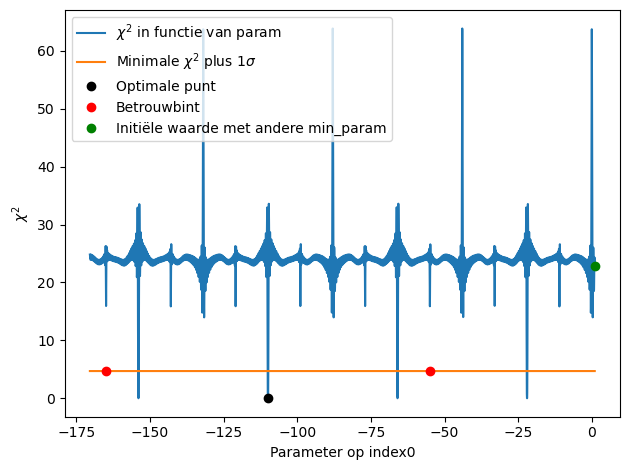

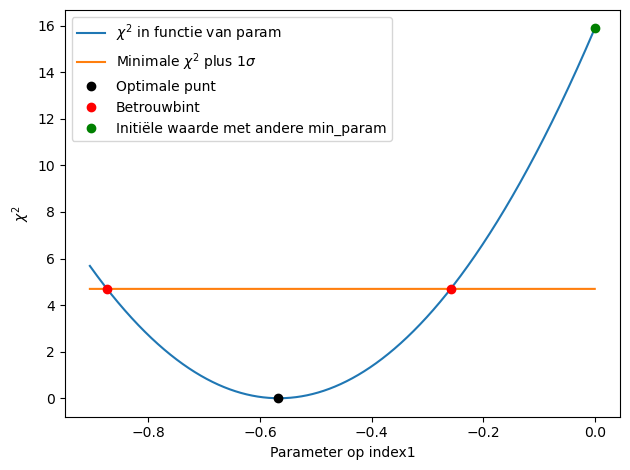

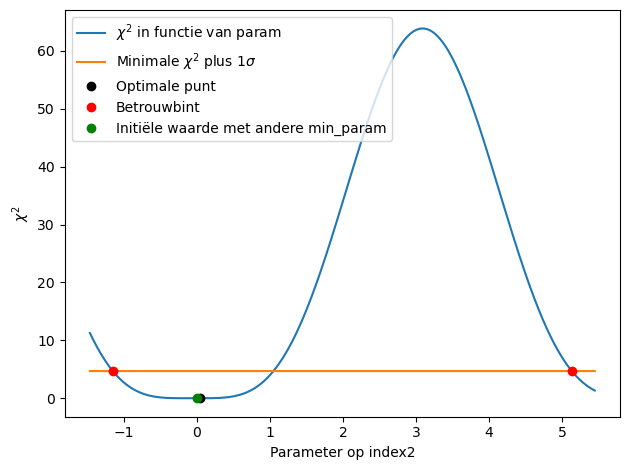

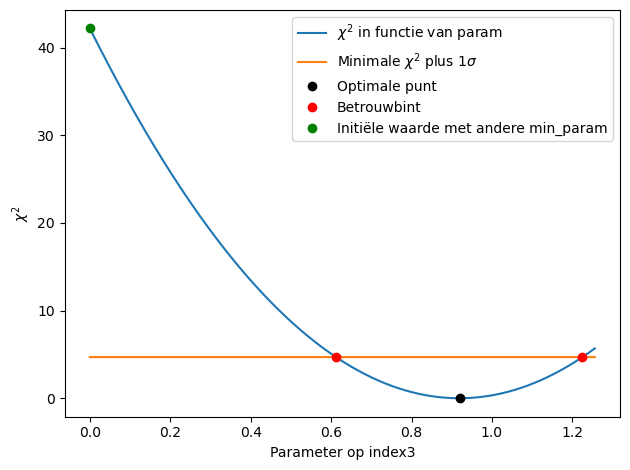

De p-waarde voor de hypothese test dat het model zinvol is, wordt gegeven door: 1
De gereduceerde chi^2 waarde is: 3.0708e-06



[[-109.94929037911893, 55.0, 'S'], [-0.5670440075686156, 0.31, 'S'], [0.04024826440110345, (1.2, 5.1), 'S'], [0.9194892966141706, 0.31, 'S']] tijdfit


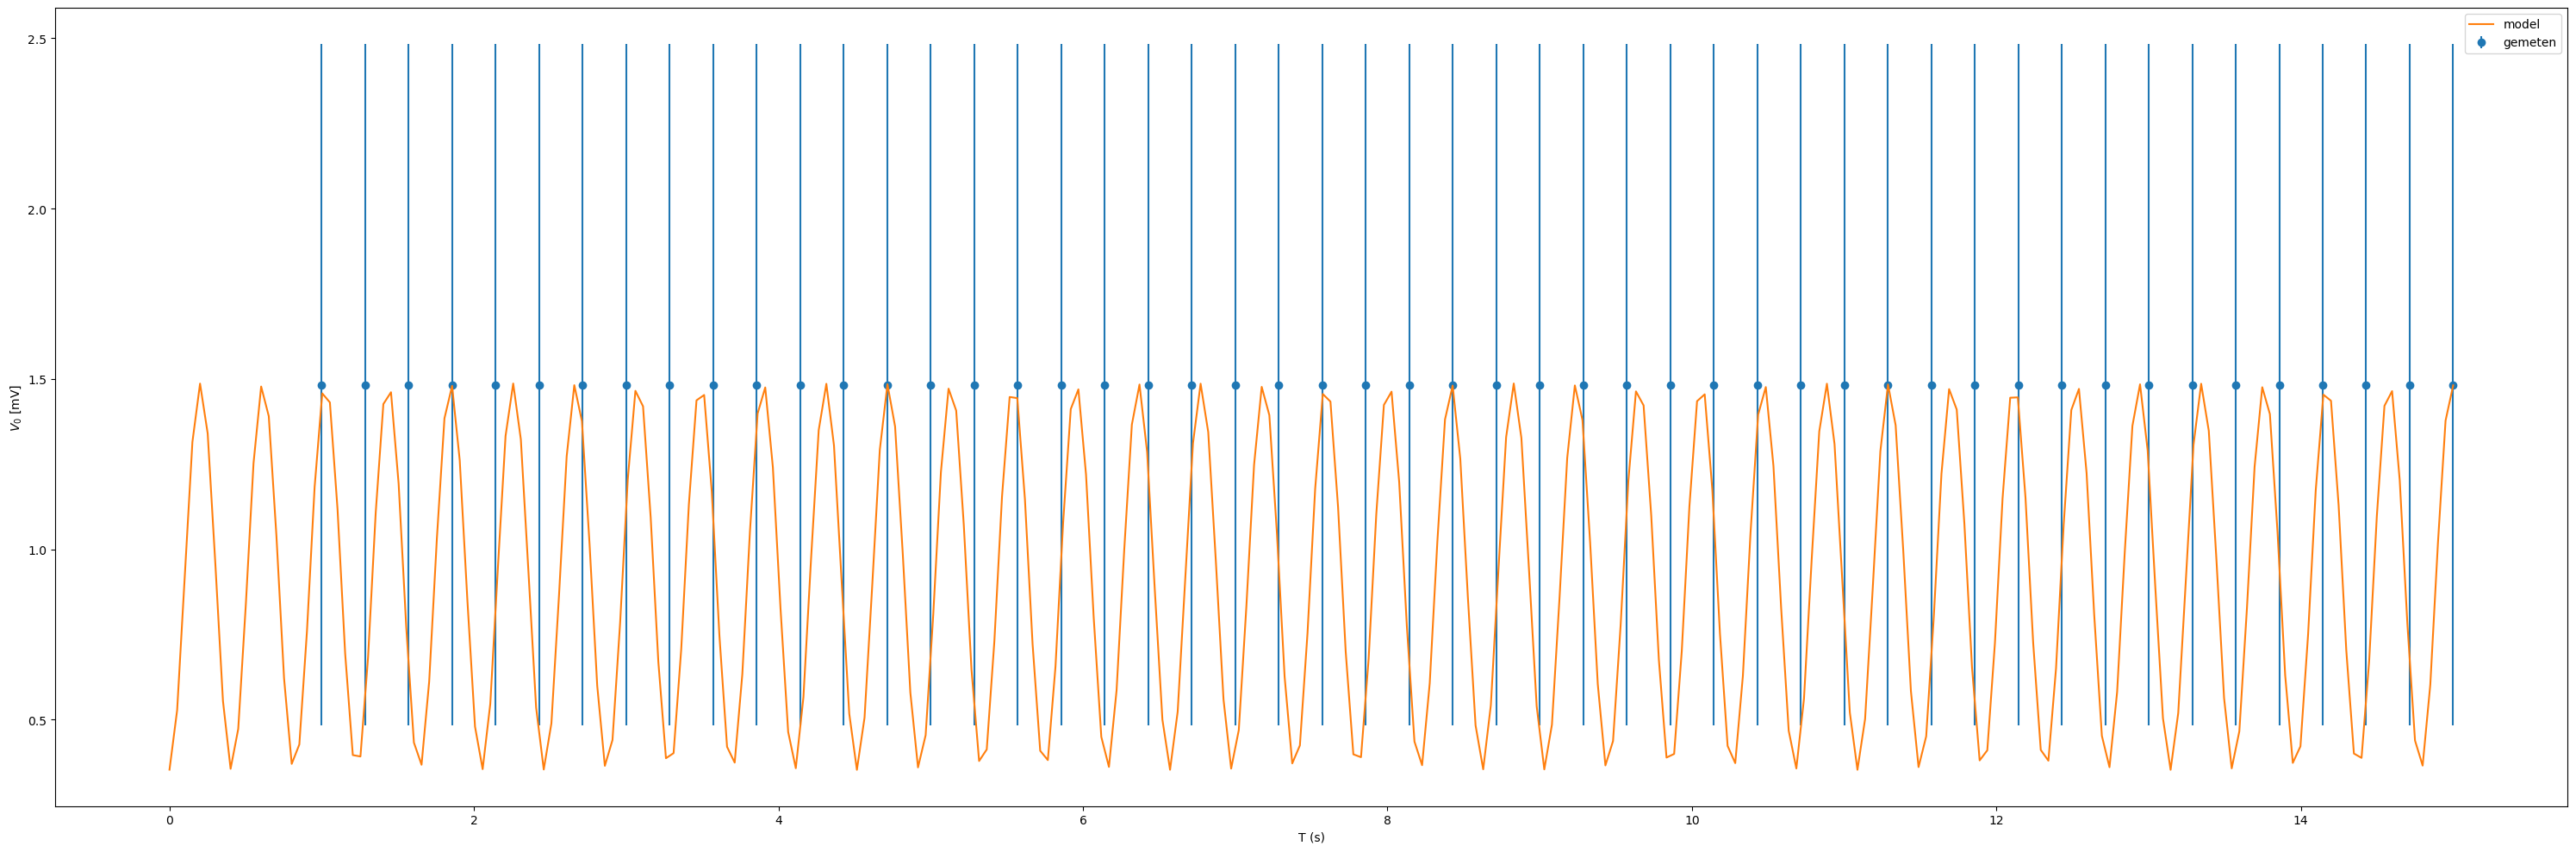

Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 5.431103267666278
             x: [-1.477e+01 -2.691e-03 -6.086e-02  7.315e-01]
           nit: 200
          nfev: 355
 final_simplex: (array([[-1.477e+01, -2.691e-03, -6.086e-02,  7.315e-01],
                       [-1.477e+01, -2.689e-03, -6.086e-02,  7.315e-01],
                       ...,
                       [-1.477e+01, -2.690e-03, -6.086e-02,  7.315e-01],
                       [-1.477e+01, -2.693e-03, -6.085e-02,  7.315e-01]]), array([ 5.431e+00,  5.431e+00,  5.431e+00,  5.431e+00,
                        5.431e+00]))
[[429.7990478348419, -645.3035662943194], [-0.4326223114640442, 0.4272413569859514], [9.2753196771539, 2.9885624615609876], [0.42501422521040516, 1.0379039261604908]]
omega heeft als waarde: -14.768 + -630.54 - -444.57 met 68% betrouwbaarheidsinterval: [429.8, -645.3] 
p_0_x heeft als waarde: -0.0026914 + 0.42993 - 0.42993 met 68% betrouwbaarh

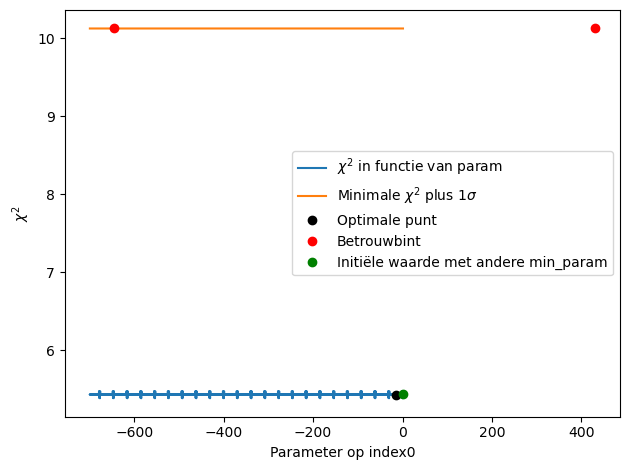

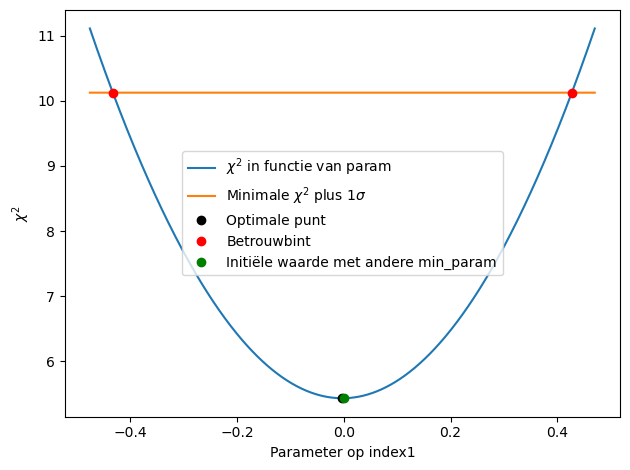

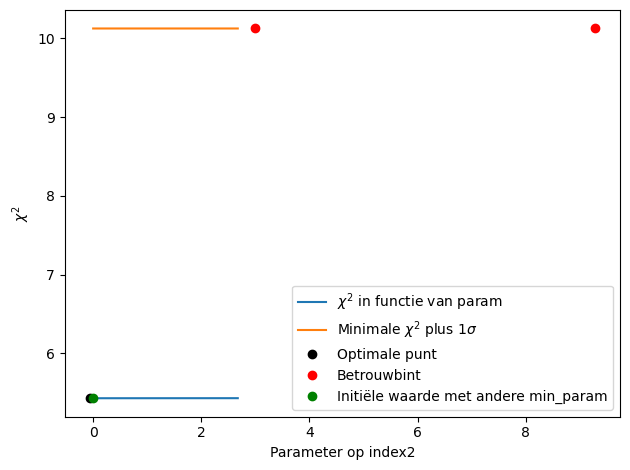

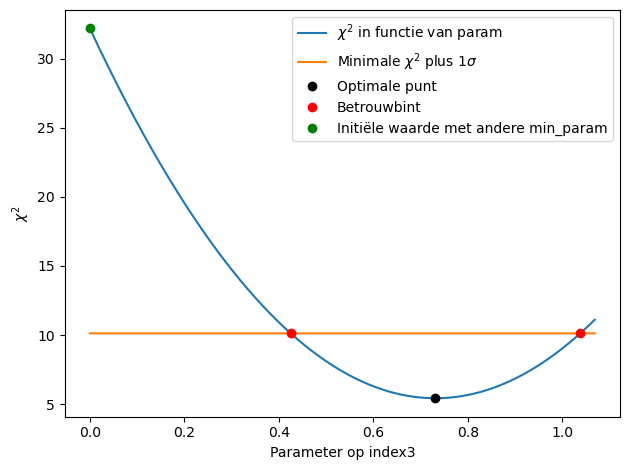

De p-waarde voor de hypothese test dat het model zinvol is, wordt gegeven door: 1
De gereduceerde chi^2 waarde is: 0.11807



[[-14.76787750692105, (-440.0, -630.0), 'S'], [-0.0026914082249076673, 0.43, 'S'], [-0.06085523307028419, (-9.3, 3.0), 'S'], [0.7314595275532321, 0.31, 'S']] tijdfit


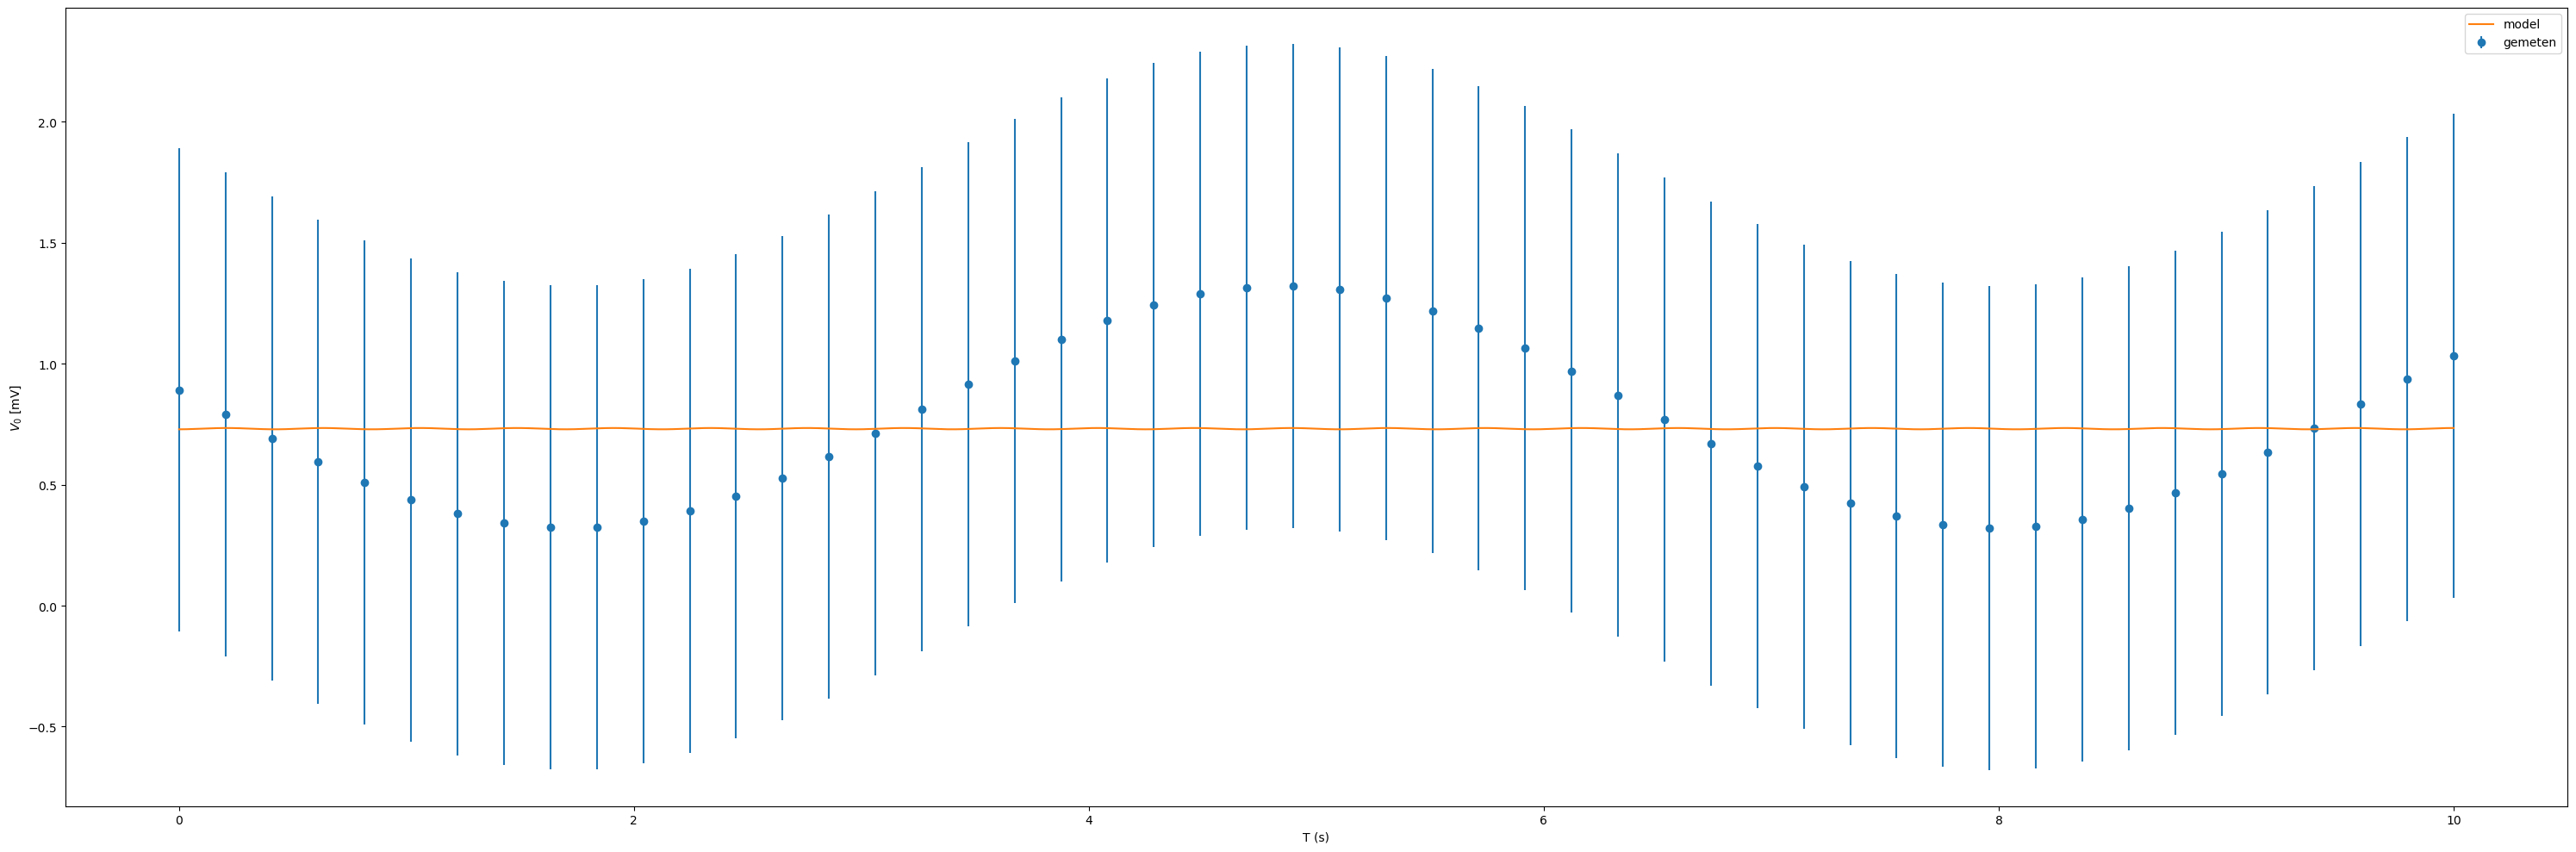

Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 6.214938780789679e-08
             x: [ 1.000e+00 -1.000e+00  1.143e+00  3.165e-06]
           nit: 340
          nfev: 563
 final_simplex: (array([[ 1.000e+00, -1.000e+00,  1.143e+00,  3.165e-06],
                       [ 1.000e+00, -1.000e+00,  1.143e+00, -1.975e-05],
                       ...,
                       [ 1.000e+00, -1.000e+00,  1.143e+00, -3.414e-05],
                       [ 1.000e+00, -1.000e+00,  1.143e+00, -5.502e-05]]), array([ 6.215e-08,  9.689e-08,  1.184e-07,  1.209e-07,
                        1.468e-07]))
[[1.0665319949311185, 2.306308397499895], [-1.4311553988480223, -0.568839735927627], [0.7106487404318252, 1.5890125642731867], [0.3064549136486672, 0.3064549136486674]]
omega heeft als waarde: 1 + 1.3063 - -0.066527 met 68% betrouwbaarheidsinterval: [1.0665, 2.3063] 
p_0_x heeft als waarde: -0.99996 + 0.43112 - 0.4312 met 68% betrouwbaarhe

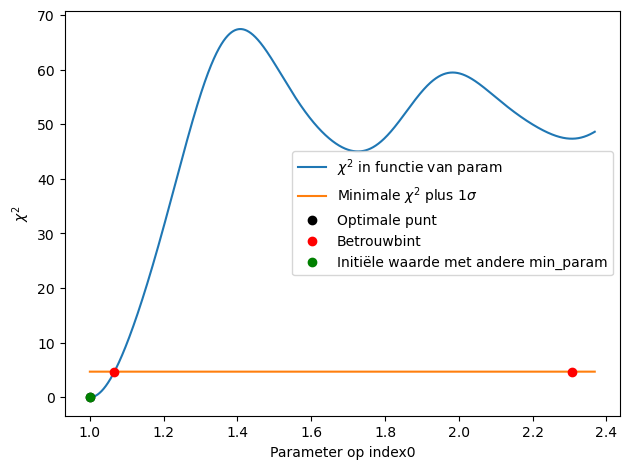

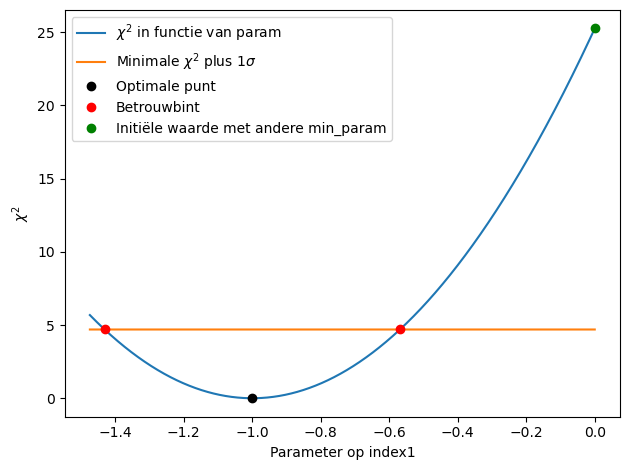

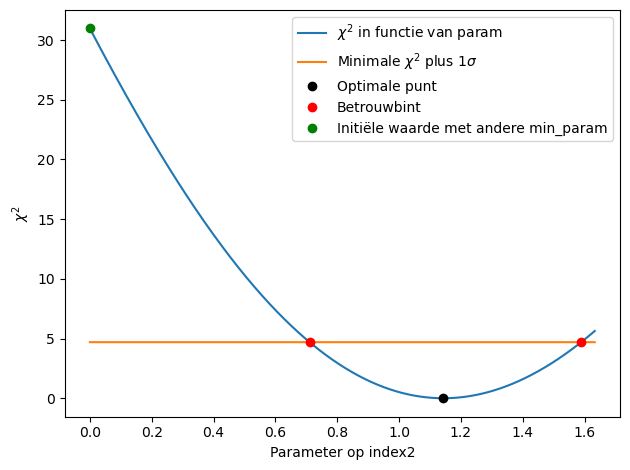

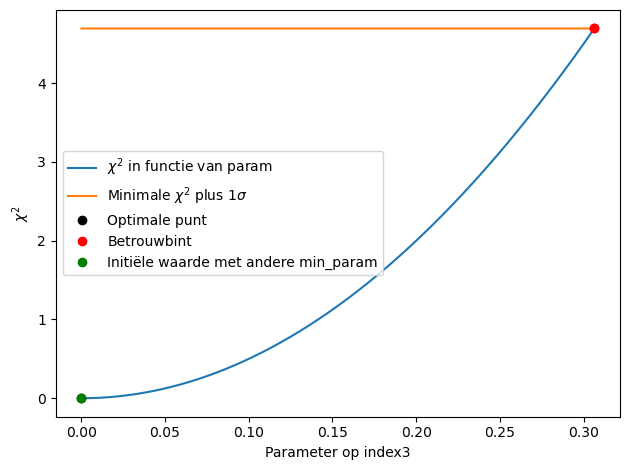

De p-waarde voor de hypothese test dat het model zinvol is, wordt gegeven door: 1
De gereduceerde chi^2 waarde is: 1.3511e-09



[[1.000004977849462, (-0.067, 1.3), 'S'], [-0.9999553119917208, 0.43, 'S'], [1.1432825099998618, 0.45, 'S'], [3.1650225525926747e-06, 0.31, 'S']] tijdfit


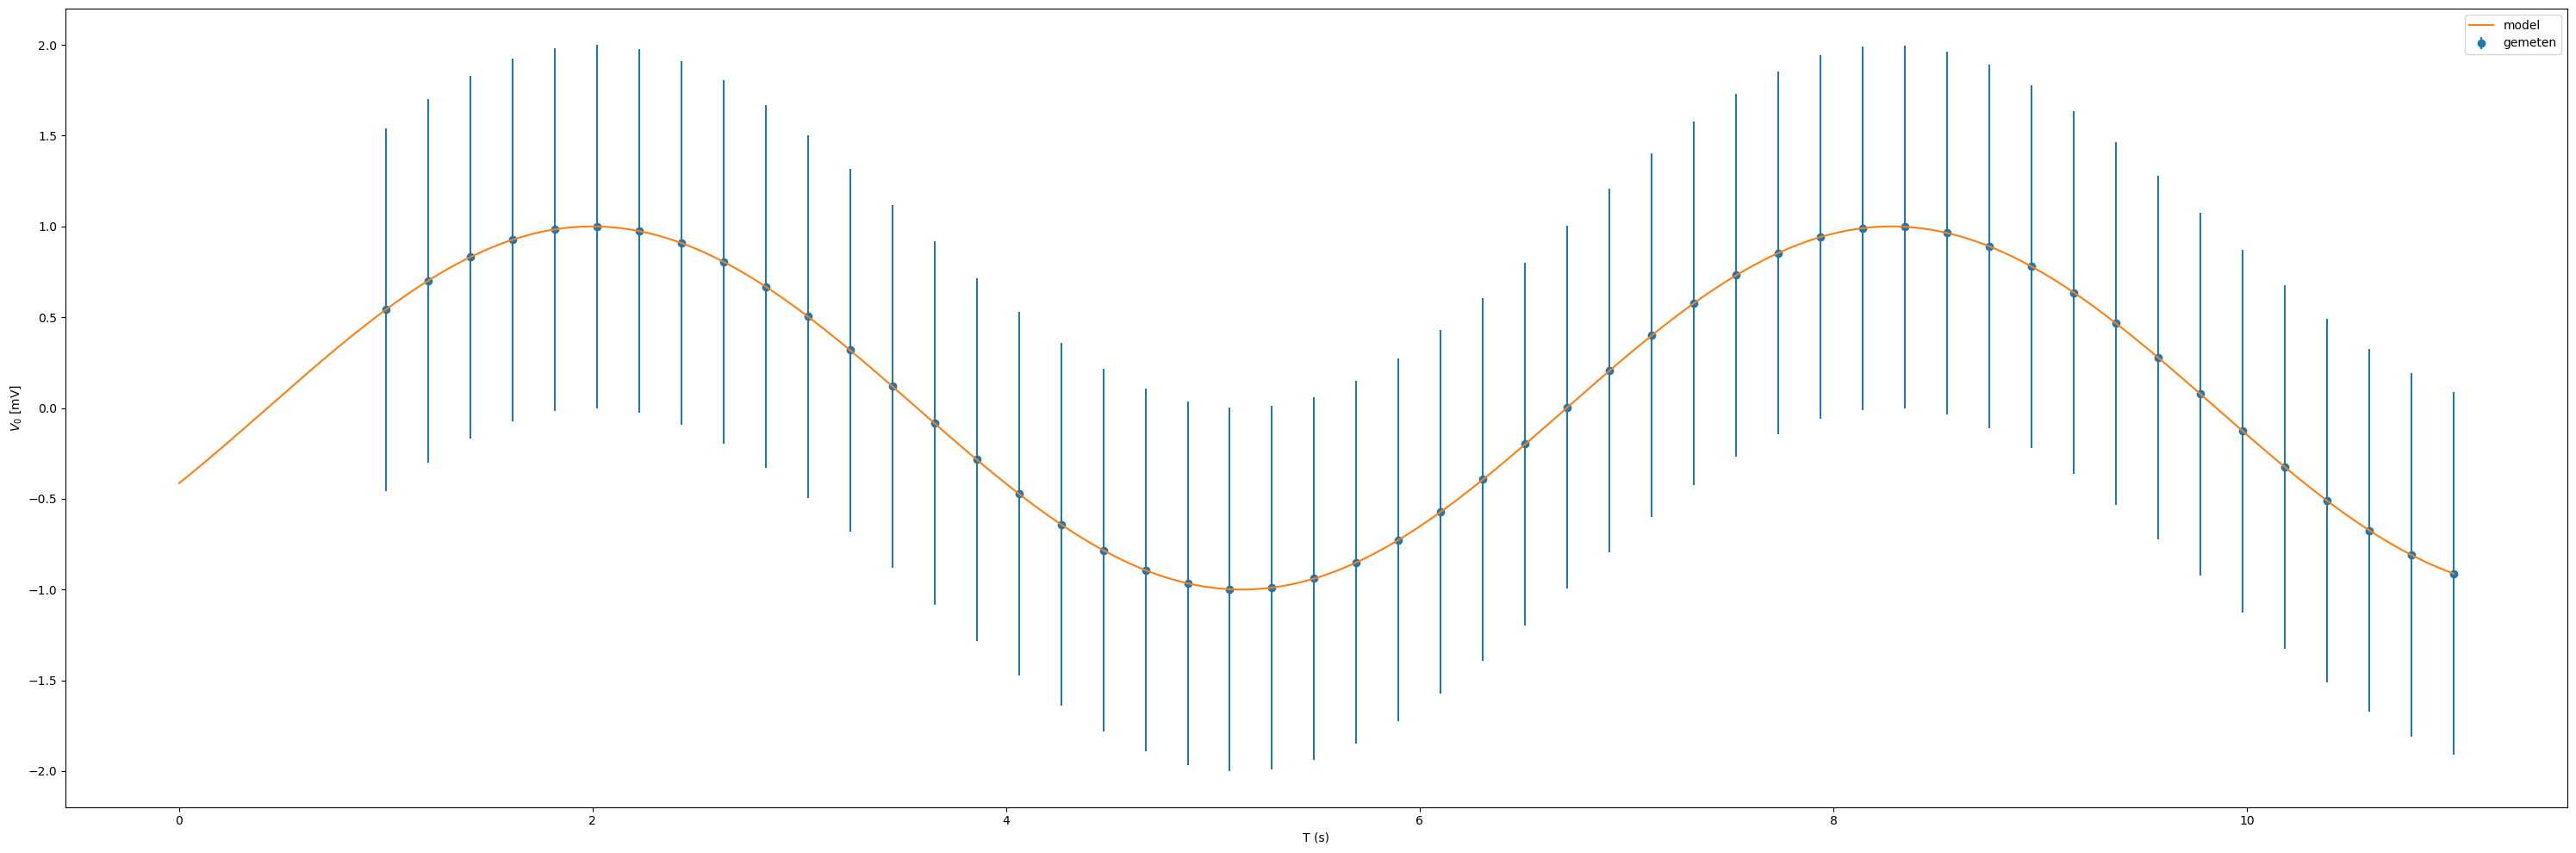

Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 3.680819113950777
             x: [-3.468e-01 -3.011e-01  1.627e-02  1.145e-01]
           nit: 146
          nfev: 251
 final_simplex: (array([[-3.468e-01, -3.011e-01,  1.627e-02,  1.145e-01],
                       [-3.468e-01, -3.012e-01,  1.623e-02,  1.146e-01],
                       ...,
                       [-3.468e-01, -3.011e-01,  1.625e-02,  1.145e-01],
                       [-3.468e-01, -3.011e-01,  1.627e-02,  1.145e-01]]), array([ 3.681e+00,  3.681e+00,  3.681e+00,  3.681e+00,
                        3.681e+00]))
[[-0.966436309288429, -0.16444610330212647], [-0.7148390220696829, 0.1231380427645471], [-1.3961799883901018, -1.3961799883901016], [-0.18471020140251432, 0.42835314390007984]]
omega heeft als waarde: -0.34684 + 0.18239 - 0.6196 met 68% betrouwbaarheidsinterval: [-0.96644, -0.16445] 
p_0_x heeft als waarde: -0.30111 + 0.42424 - 0.41373 met 68%

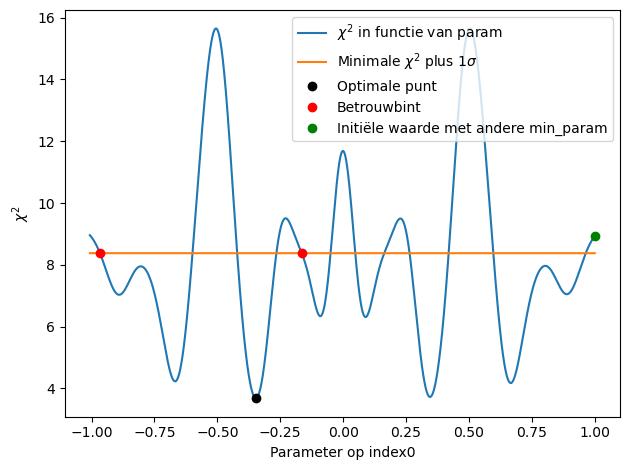

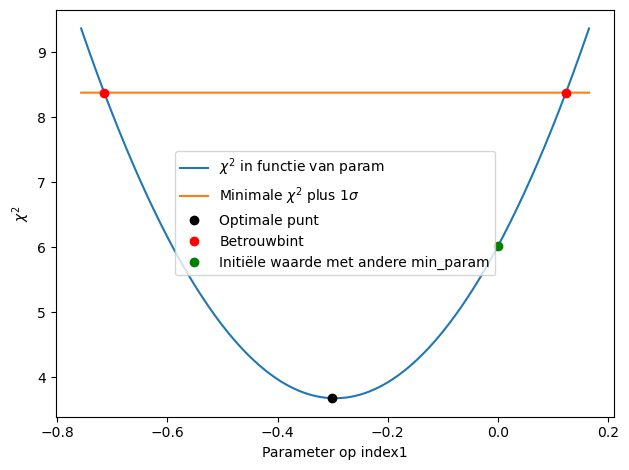

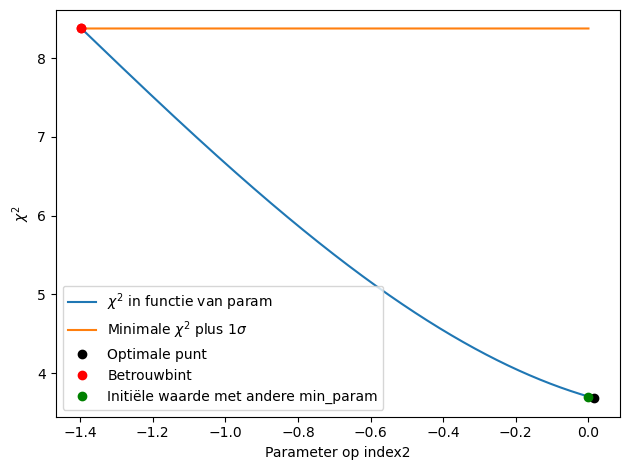

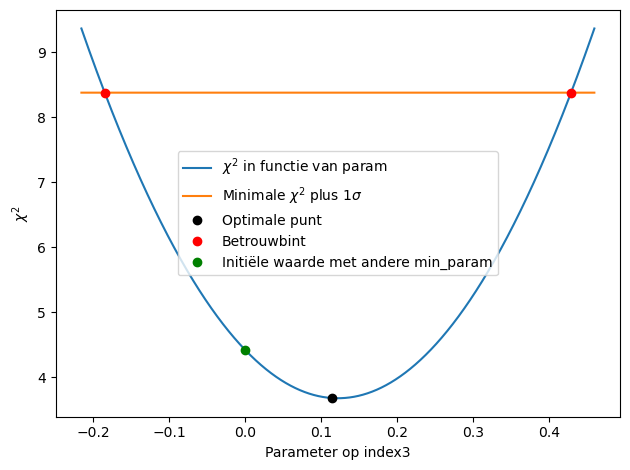

De p-waarde voor de hypothese test dat het model zinvol is, wordt gegeven door: 1
De gereduceerde chi^2 waarde is: 0.080018



[[-0.34683645492279935, (0.62, 0.18), 'S'], [-0.3011050601509402, 0.42, 'S'], [0.016266108837168107, 1.4, 'S'], [0.11452627036445016, 0.31, 'S']] tijdfit


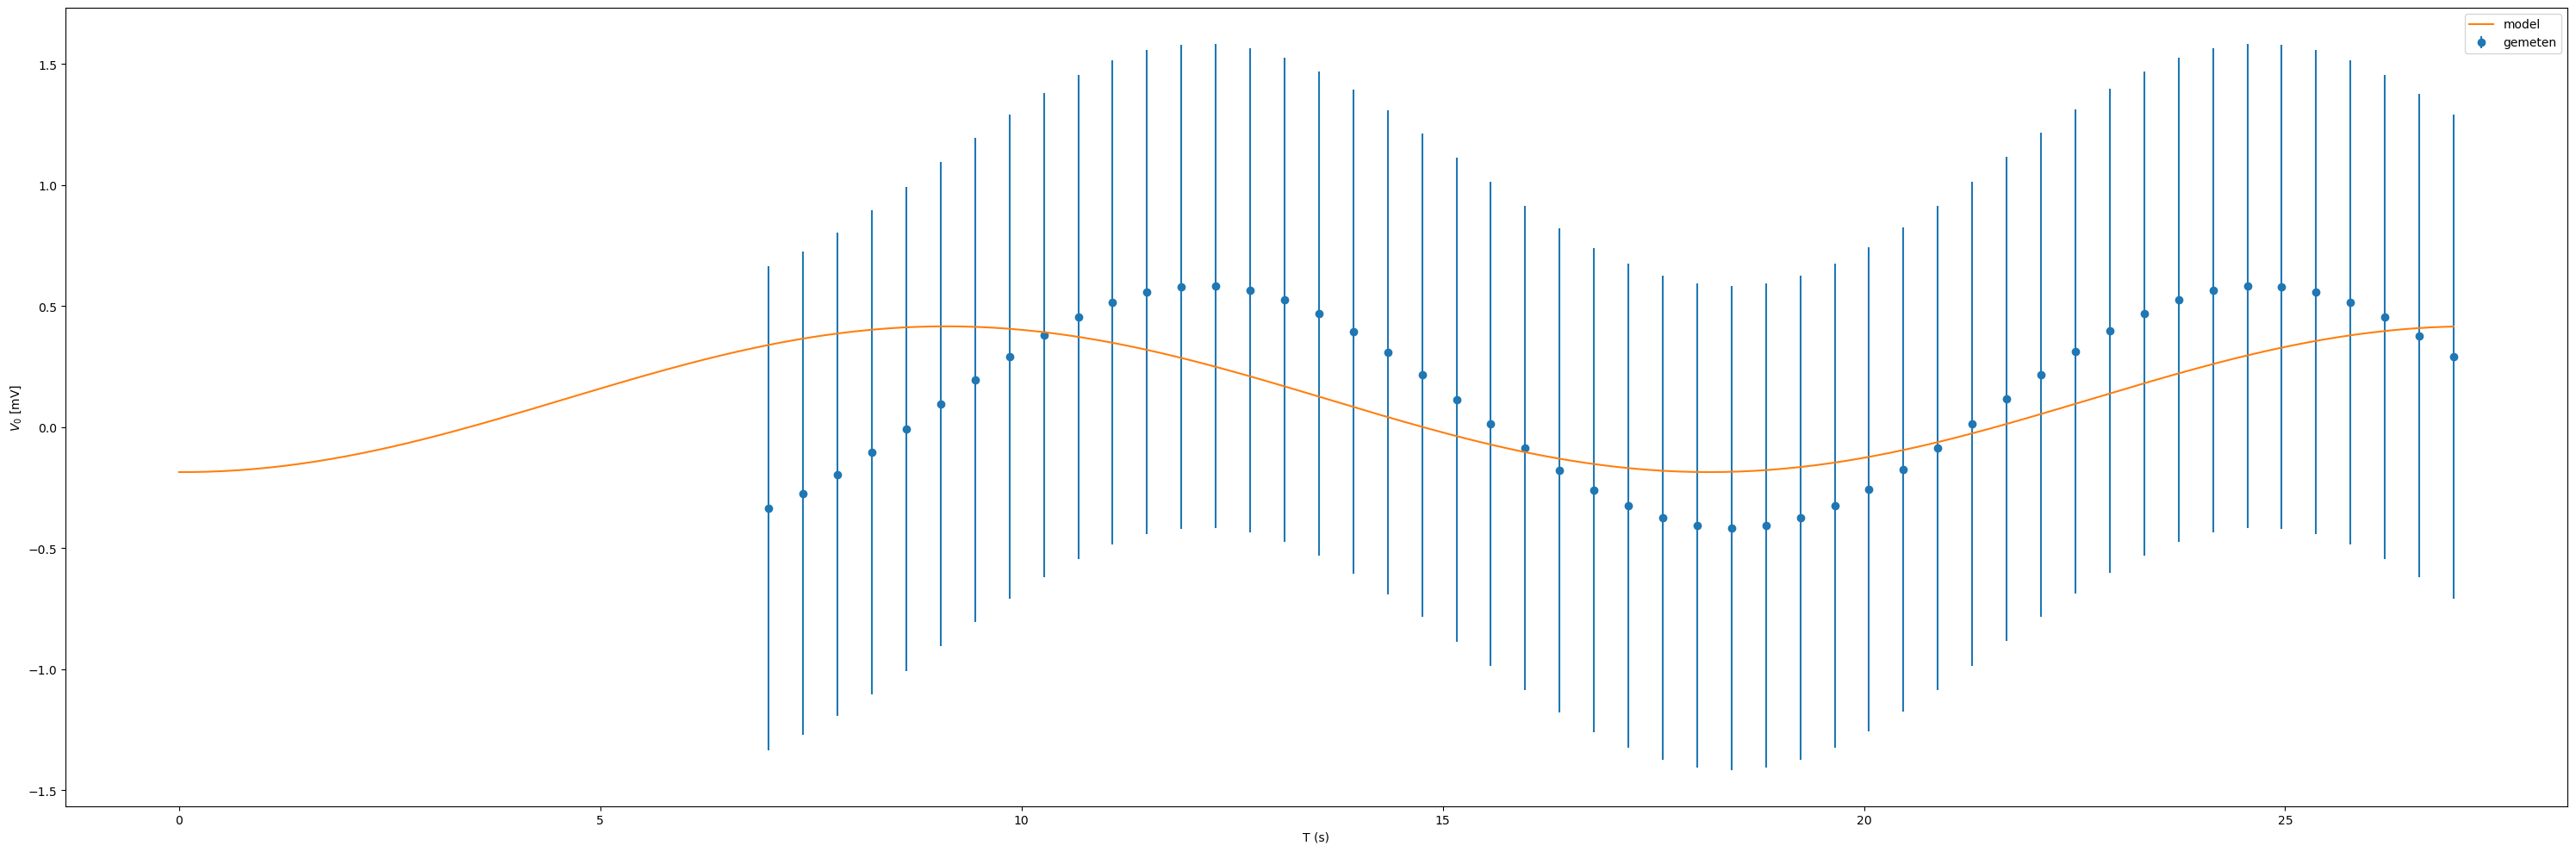

[0.31, 0.43, 0.43, 0.42] P_0(x): de error
Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.23699601391804484
             x: [ 2.306e-02  3.978e-01 -1.318e-01 -1.290e+00]
           nit: 249
          nfev: 430
 final_simplex: (array([[ 2.306e-02,  3.978e-01, -1.318e-01, -1.290e+00],
                       [ 2.306e-02,  3.978e-01, -1.318e-01, -1.290e+00],
                       ...,
                       [ 2.306e-02,  3.978e-01, -1.317e-01, -1.290e+00],
                       [ 2.306e-02,  3.978e-01, -1.319e-01, -1.290e+00]]), array([ 2.370e-01,  2.370e-01,  2.370e-01,  2.370e-01,
                        2.370e-01]))
[[0.007230984351987154, 0.03391209350794782], [0.114420040419431, 0.7069569185511122], [-39.33233848718682, 26.3490441937942], [-2.2904154750280687, -0.06563799507181563]]
k heeft als waarde: 0.023062 + 0.01085 - 0.015831 met 68% betrouwbaarheidsinterval: [0.007231, 0.033912] 
p_0 heeft als waarde: 0

c:\Users\samfa\Python\Experimentele_vscode\functies.py:301: RuntimeWarning: divide by zero encountered in scalar divide
  chi_red = chi_min/nu


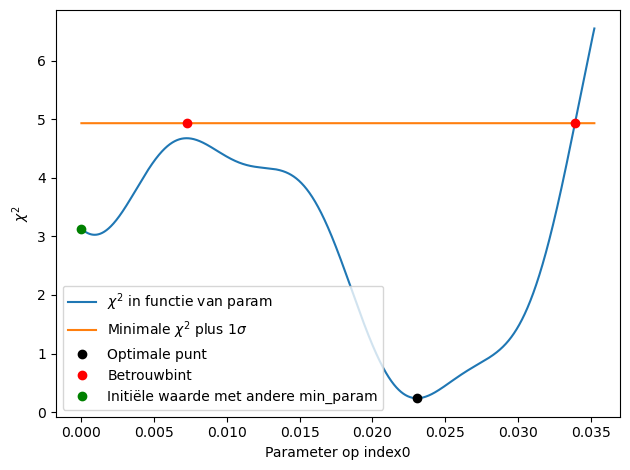

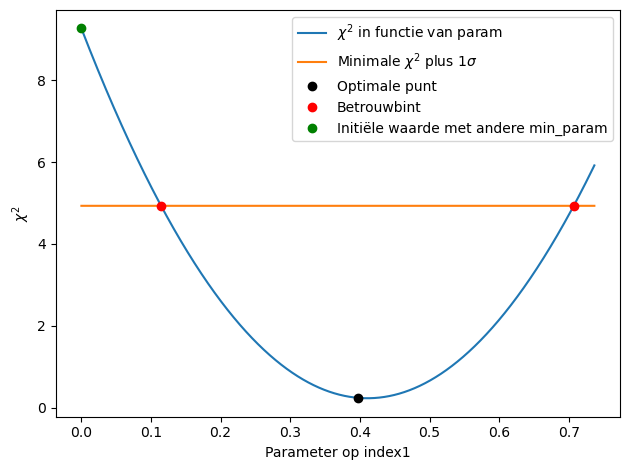

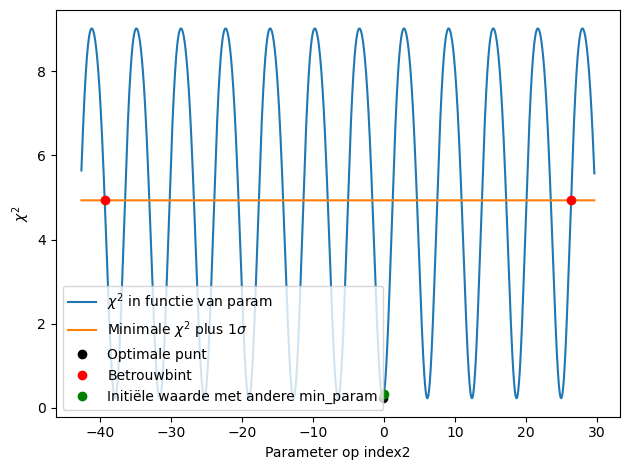

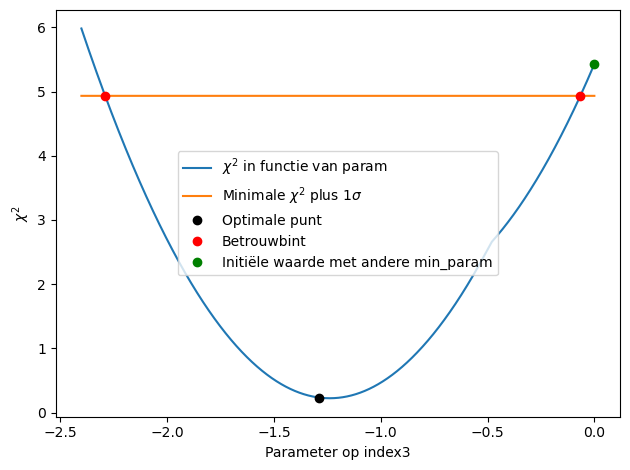

De p-waarde voor de hypothese test dat het model zinvol is, wordt gegeven door: nan
De gereduceerde chi^2 waarde is: inf


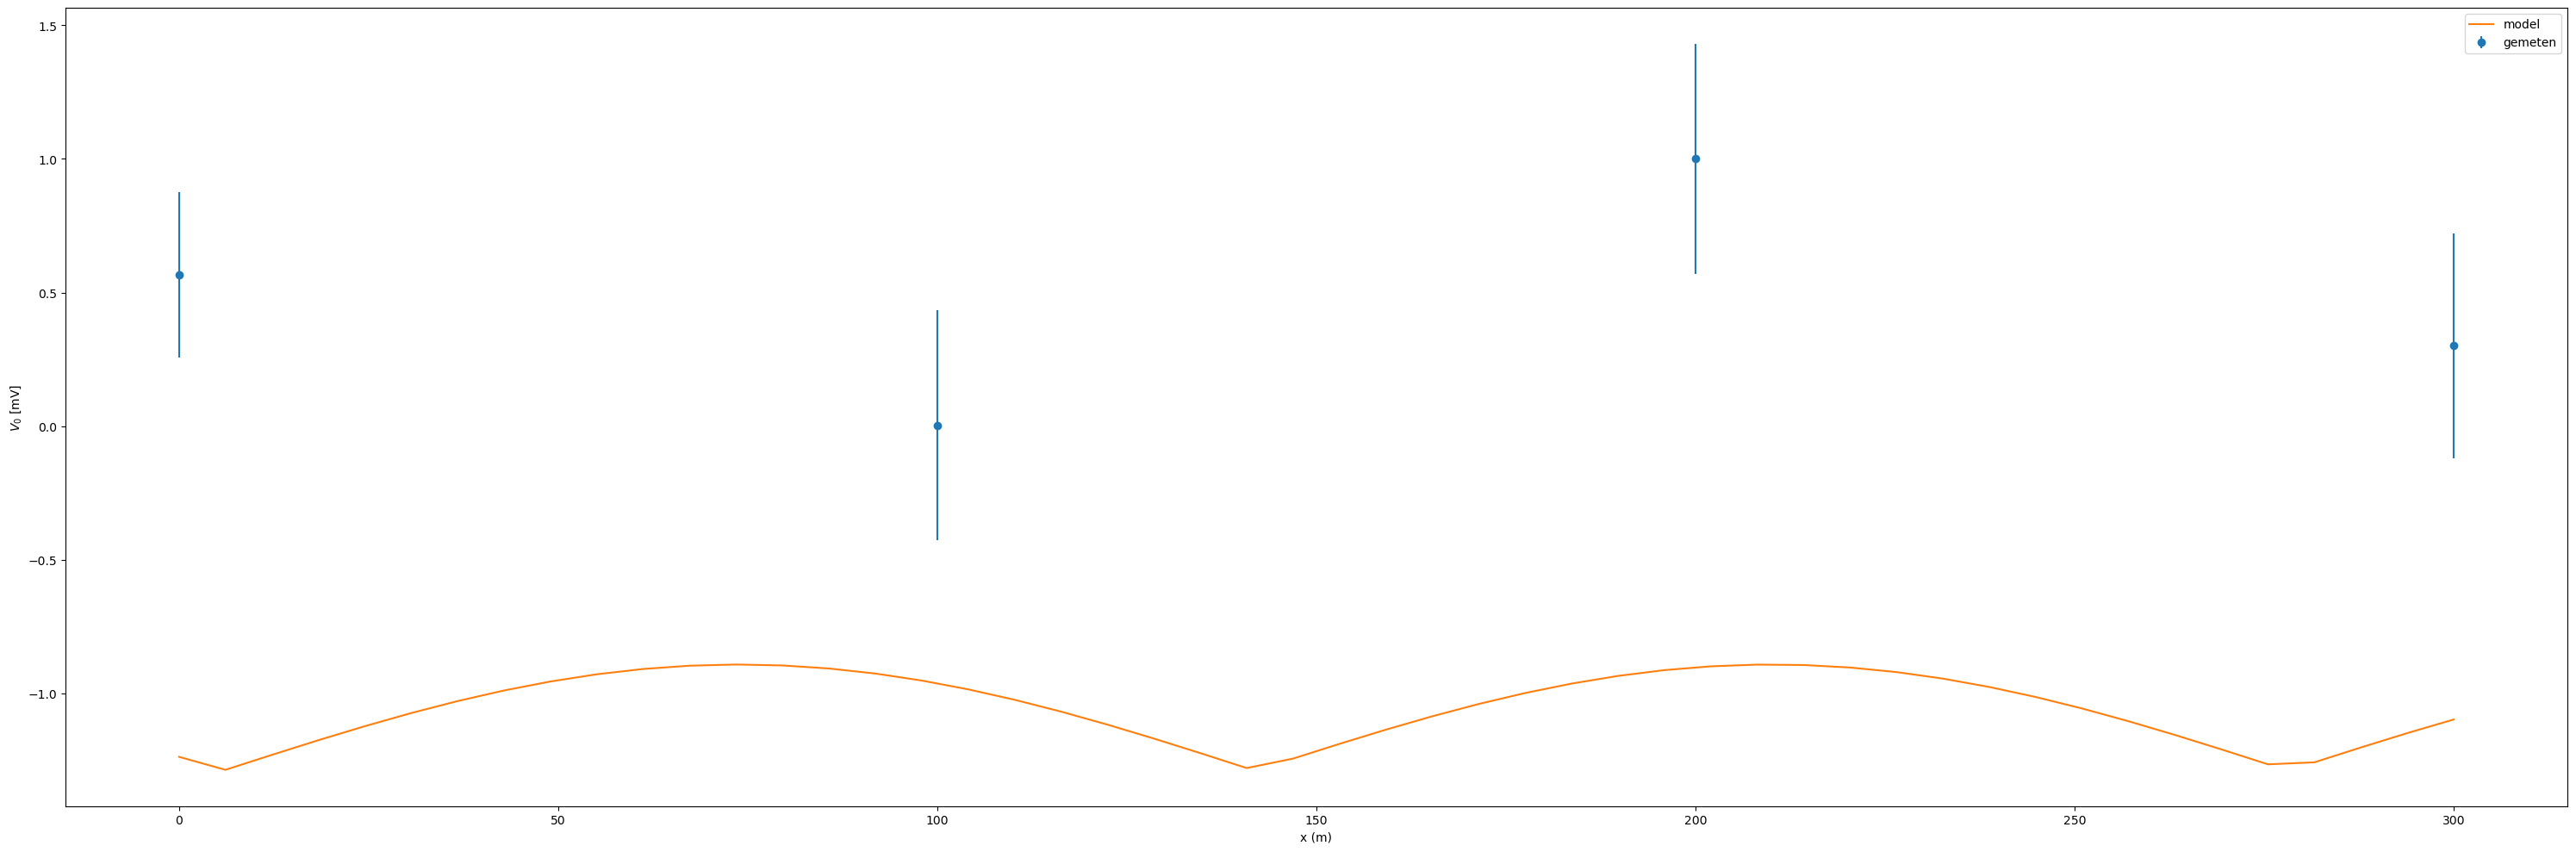

datapunt: v = [-4.03721125322837, 25.3069441722265, 'Normaal']


In [44]:
#### Hier volgt de effectieve data-analyse
fix_data(X, T, P, P_fout, detailed_logs=True)

In [45]:
def X_tractor(inhoud): #extraheert effectief nuttige data uit die txt-files
    #bepaal de initiële values van de fit (met de headerdata)
    amplitude = float(inhoud.split("PK-PK                :		")[1][:4])/2 #de helft van de peak-to-peak +20 om te kleine fits te breken
    freq = float(inhoud.split("Frequency            :		")[1][:4]) * 10**3 #het staat in kHz
    gesplit = inhoud.split('Time interval        :		')

    #bepaal de stapbreedte
    getal = ""
    eenheid = ""
    count = 0
    for digit in gesplit[1]:
        if digit.isdigit():
            getal+=digit
        else:
            eenheid+=digit
            count+=1
        if count == 3:
            break
    getal = float(getal)
    #fix de SI prefix van de stapbreedte
    if eenheid == ".us": #bro een u voor µ deze oscilloscoop is ass
        stapbreedte = getal *10**(-6)
    elif eenheid == ".ms":
        stapbreedte = getal * 10**(-3)
    else:
        raise ChildProcessError("children have defined units of " + eenheid)
    #haal de twee kolommen uit de txt-file en transponeer ze
    tabel = gesplit[1].split('index		CH1_Voltage(mV)\n')[1]
    nuttigtransponent = [X.split('		') for X in tabel.split('\n')][:-1] #skip het laatste element want dat is leeg (een enter op het einde van de txt)
    nuttig = [[float(nuttigtransponent[j][i]) for j in range(len(nuttigtransponent))] for i in range(len(nuttigtransponent[0]))]
    #fix de verder gebruikte arrays in analyse
    T = np.array(nuttig[0])*stapbreedte
    T = T - T[0] #gezien het toch periodisch is kunnen we het laten starten bij nul
    Vpart = np.array(nuttig[1])        
    
    C = (np.max(Vpart)+np.min(Vpart))/2 #zou ook moeten werken i guess
    

    if Vpart[0] < Vpart[1]:
        phi = np.arcsin((Vpart[0] - C)/amplitude)
    else:
        phi = np.pi - np.arcsin((Vpart[0] - C)/amplitude)

    

    
    invals = [2*np.pi*freq*10**(-5), amplitude, phi, C] #Was eerder 4*pi*freq, maar omega=2pif, dus idk wat het plan was
    #Eenheden zijn enorm cooked, 10^-5 factor moet nog bij freq om shit te doen kloppen, zie twee code blokken verder, hier wat getest (werkte op oude code)
    return T, Vpart, eenheid, invals

In [ ]:
#experiment 1: 1000 Hz, 35,3cm
mypath = "metingen laweit/1000Hz, 35.3cm"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))] #met dank aan StackOverflow: een lijst met alle files in mypath
afstanden = []
T = []
V = []
invals = []
for i in range(5):
#for filenaam in onlyfiles: -------- Ik heb er ff voor gezorgd dat enkel de eerste 5 files gefit worden voor debugging purposes
    filenaam = onlyfiles[i]
    nummer = float(filenaam[9:-4])*10**(-3)
    afstanden.append(nummer)
    bestand = open(mypath + '/' +filenaam,'rt')
    inhoud = bestand.read()
    bestand.close()
    Tpart, Vpart, eenheid, invals_vaste_x = X_tractor(inhoud)
    if nummer != 0:
        assert eenheid0 == eenheid
    else:
        eenheid0 = eenheid
    V.append(Vpart[::2].copy()) #Dubbele sinusfunctie moet unzipped worden, dus om de index pakken als fix. Tis nogsteeds kapot, 
    #maar wss zullen amplitude en freq hetzelfde zijn, gwn andere +C
    T.append(Tpart[::2].copy())
    invals.append(invals_vaste_x.copy())
V = np.array(V)
afstanden = np.array(afstanden)
invals = np.array(invals)
T = np.array(T)
V_fout = np.full(np.shape(V), 3) #euhm pls help, ik heb hier 0.1 mV genomen als de fout op de spanning


In [71]:
"""inval = invals[0]
display(inval[0]*0.0001)
display(inval[2])
display(T[0])
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.errorbar(T[0], V[0], yerr= V_fout[0], fmt='o')
temp = np.linspace(0,2000,10000)
ax.plot(temp, inval[1]*np.sin(inval[0]*temp*0.00001 + inval[2]) + inval[3]) 
plt.show()"""
display(V[4])

array([ 60.546875,  66.40625 ,  64.453125, ..., -68.359375, -68.359375,
       -72.265625])

Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 23113.081673188703
             x: [ 6.665e-02  1.559e+02  9.334e-01 -2.203e+00]
           nit: 293
          nfev: 503
 final_simplex: (array([[ 6.665e-02,  1.559e+02,  9.334e-01, -2.203e+00],
                       [ 6.665e-02,  1.559e+02,  9.334e-01, -2.203e+00],
                       ...,
                       [ 6.665e-02,  1.559e+02,  9.334e-01, -2.203e+00],
                       [ 6.665e-02,  1.559e+02,  9.334e-01, -2.203e+00]]), array([ 2.311e+04,  2.311e+04,  2.311e+04,  2.311e+04,
                        2.311e+04]))
[[0.011803446243374812, 0.06664699016378609], [155.8071695943663, 156.0681518756251], [0.9325942549734472, 0.9342557030616158], [-2.2952184634478408, -2.111351546237408]]
omega heeft als waarde: 0.066646 + 7.1783e-07 - 0.054843 met 68% betrouwbaarheidsinterval: [0.011803, 0.066647] 
p_0_x heeft als waarde: 155.94 + 0.1305 - 0.13048 met 68% be

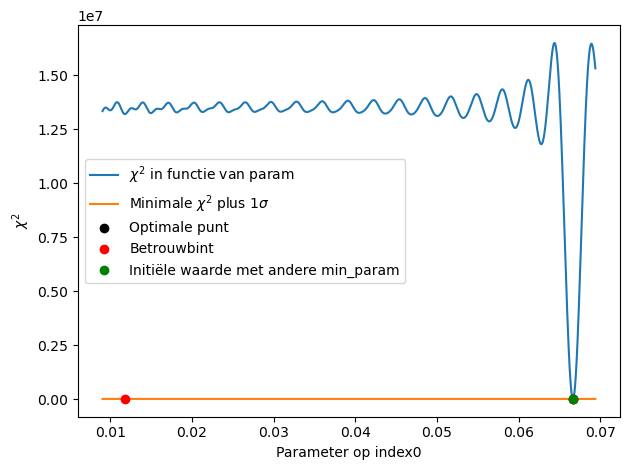

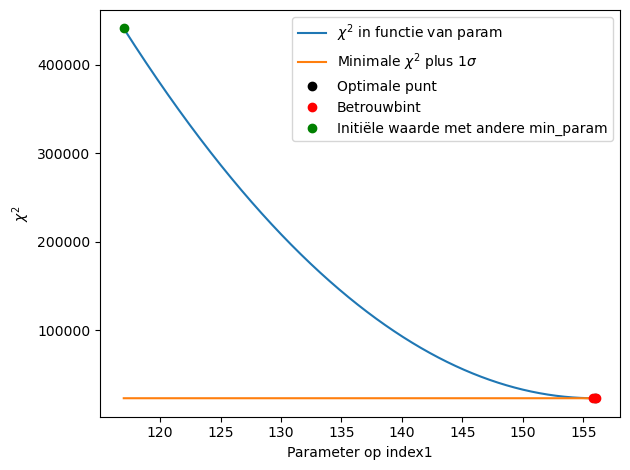

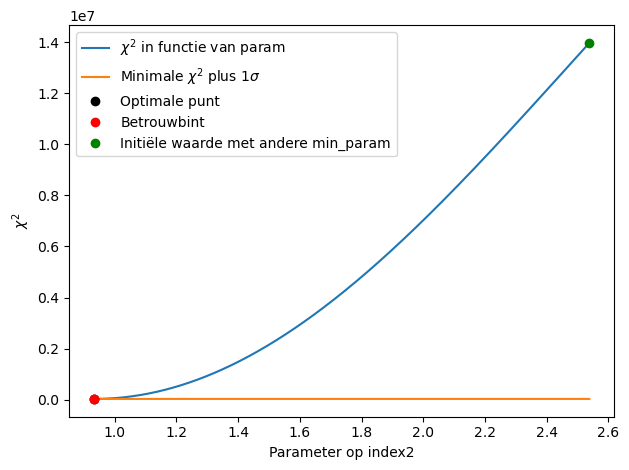

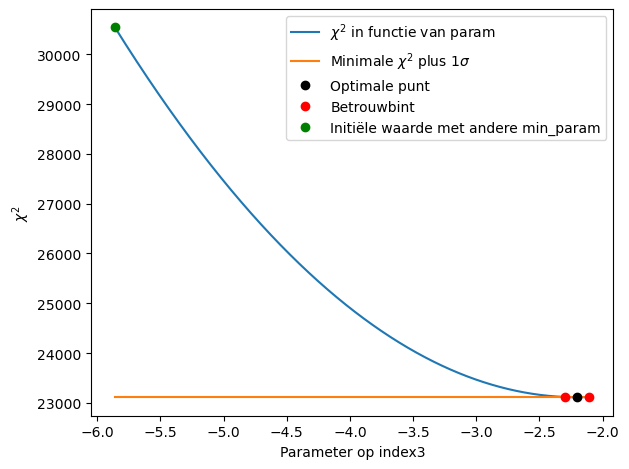

De p-waarde voor de hypothese test dat het model zinvol is, wordt gegeven door: 0
De gereduceerde chi^2 waarde is: 4.6263



[[0.06664627233346225, (0.055, 7.2e-07), 'S'], [155.93765171104235, 0.13, 'S'], [0.9334253446953393, 0.00083, 'S'], [-2.2032597736865203, 0.092, 'S']] tijdfit


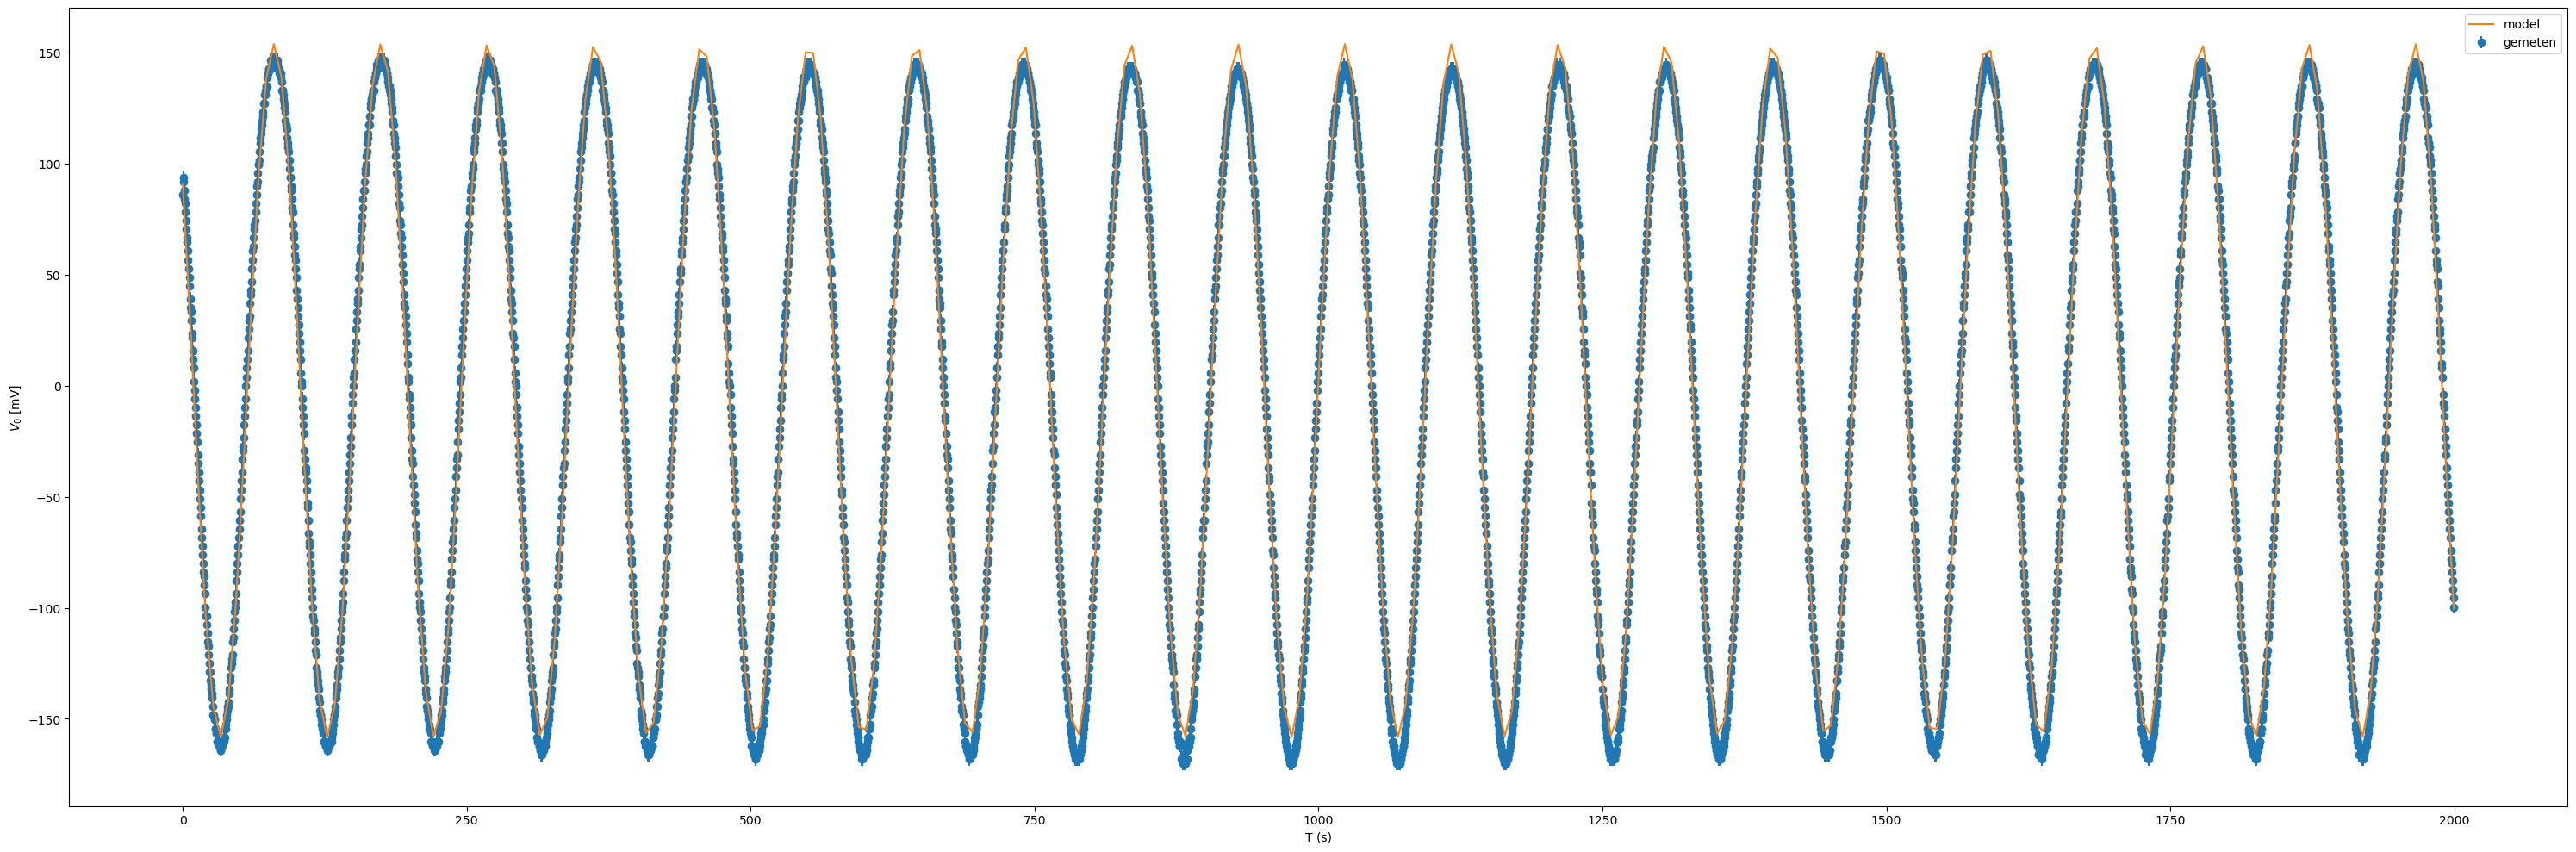

Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1460.854773091371
             x: [ 6.663e-02  2.409e+01  1.578e+00  6.285e+00]
           nit: 227
          nfev: 390
 final_simplex: (array([[ 6.663e-02,  2.409e+01,  1.578e+00,  6.285e+00],
                       [ 6.663e-02,  2.409e+01,  1.578e+00,  6.285e+00],
                       ...,
                       [ 6.663e-02,  2.409e+01,  1.578e+00,  6.285e+00],
                       [ 6.663e-02,  2.409e+01,  1.578e+00,  6.285e+00]]), array([ 1.461e+03,  1.461e+03,  1.461e+03,  1.461e+03,
                        1.461e+03]))
[[0.06662830354937169, 0.10840524062228056], [23.957477166261718, 24.217751677668563], [1.5723301125966975, 1.5831149365290798], [6.193452804372509, 6.377319730704101]]
omega heeft als waarde: 0.066633 + 0.041772 - 4.6644e-06 met 68% betrouwbaarheidsinterval: [0.066628, 0.10841] 
p_0_x heeft als waarde: 24.088 + 0.13014 - 0.13014 met 68% betro

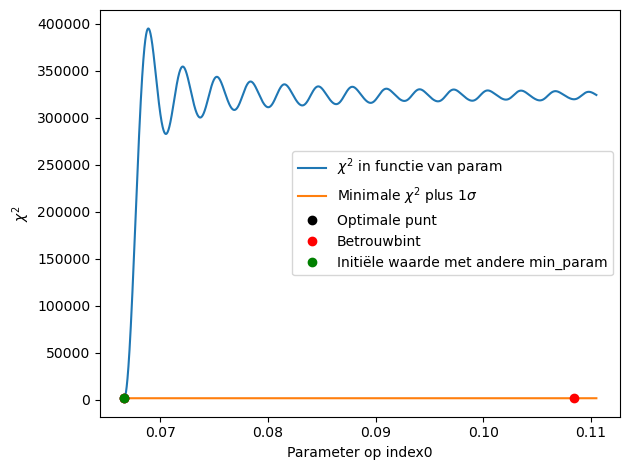

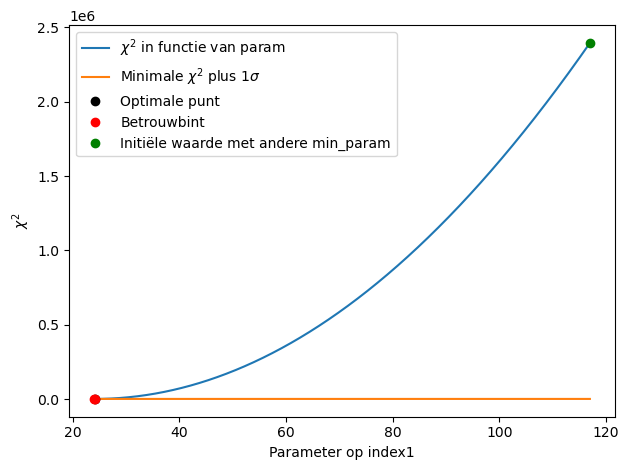

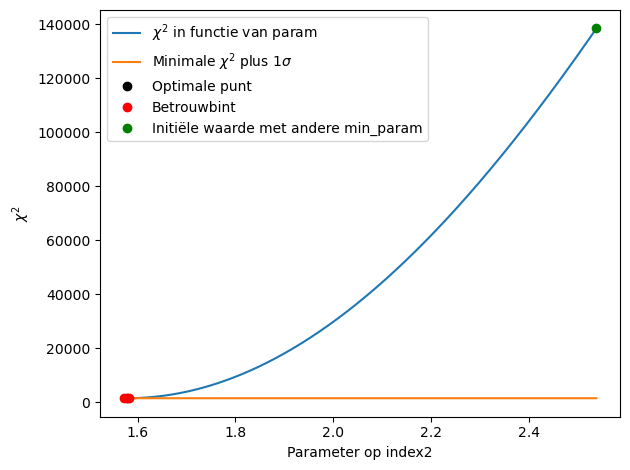

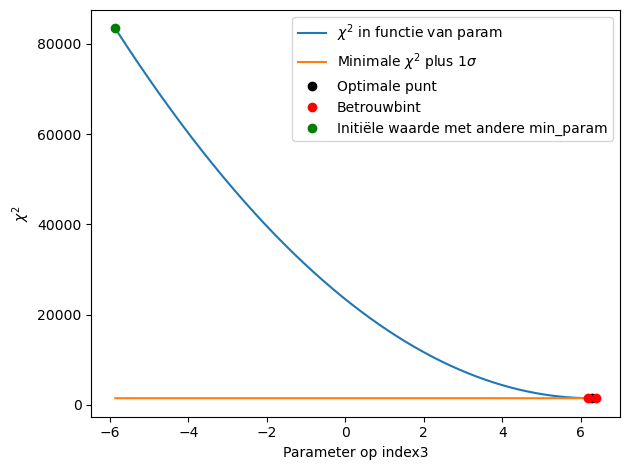

De p-waarde voor de hypothese test dat het model zinvol is, wordt gegeven door: 1
De gereduceerde chi^2 waarde is: 0.2924



[[0.06663296797506682, (4.7e-06, 0.042), 'S'], [24.08761452702558, 0.13, 'S'], [1.577724470455316, 0.0054, 'S'], [6.285424676328587, 0.092, 'S']] tijdfit


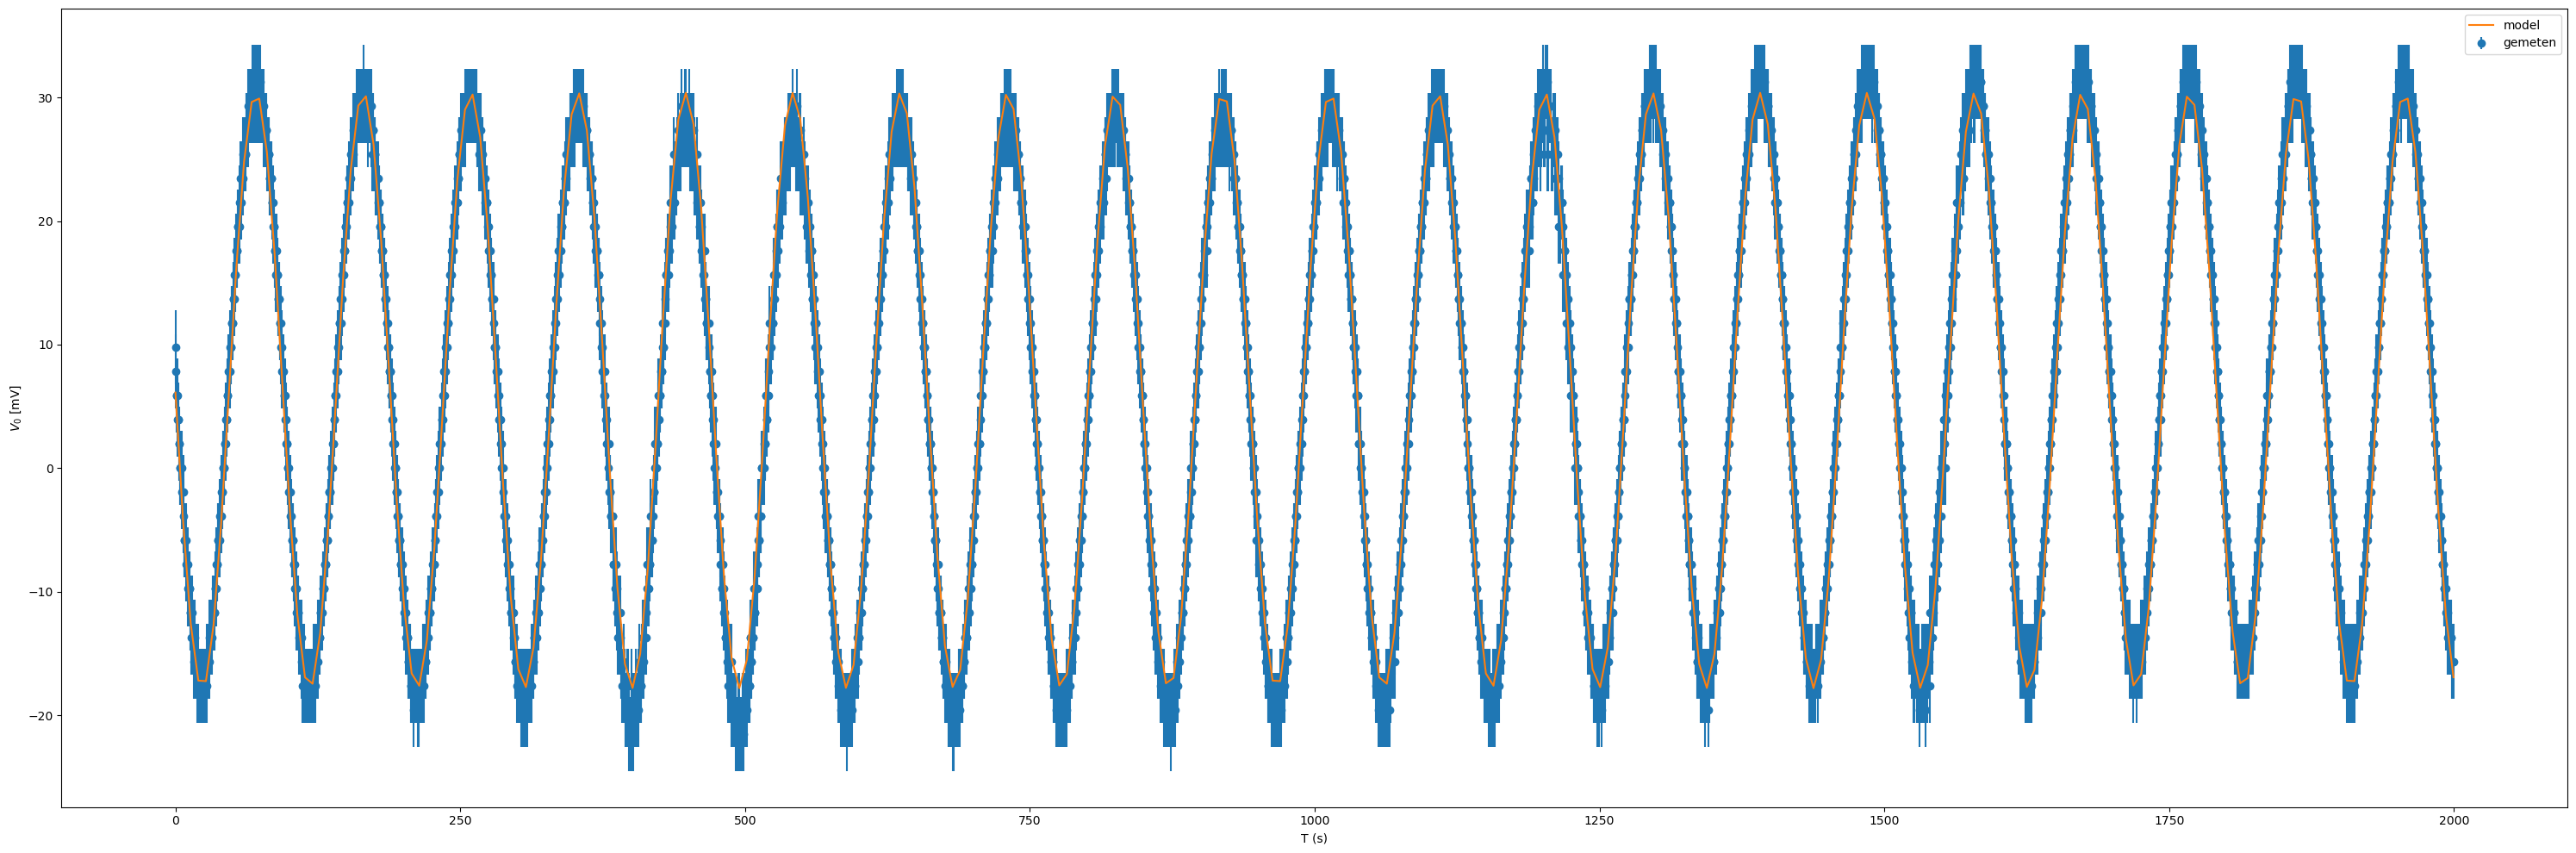

Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 2519.7786066308527
             x: [ 6.664e-02  6.074e+01  1.066e+00  6.945e+00]
           nit: 293
          nfev: 504
 final_simplex: (array([[ 6.664e-02,  6.074e+01,  1.066e+00,  6.945e+00],
                       [ 6.664e-02,  6.074e+01,  1.066e+00,  6.945e+00],
                       ...,
                       [ 6.664e-02,  6.074e+01,  1.066e+00,  6.945e+00],
                       [ 6.664e-02,  6.074e+01,  1.066e+00,  6.945e+00]]), array([ 2.520e+03,  2.520e+03,  2.520e+03,  2.520e+03,
                        2.520e+03]))
[[0.06664162050727362, 0.10842250857714138], [60.612890254826375, 60.873828514835594], [1.0635071878873872, 1.0677730943612271], [6.8532798094490825, 7.037146719814692]]
omega heeft als waarde: 0.066643 + 0.041779 - 1.8449e-06 met 68% betrouwbaarheidsinterval: [0.066642, 0.10842] 
p_0_x heeft als waarde: 60.743 + 0.13047 - 0.13047 met 68% bet

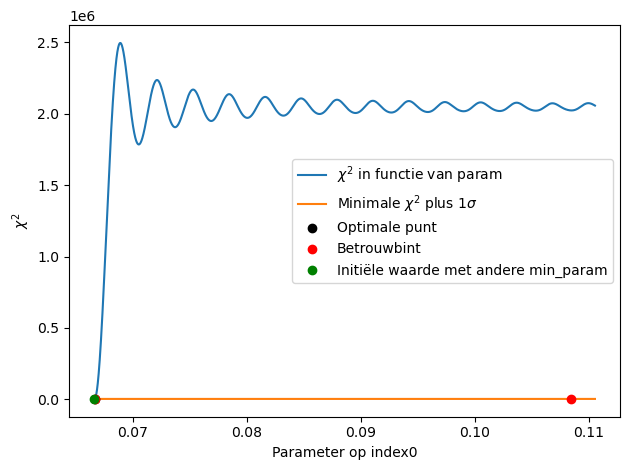

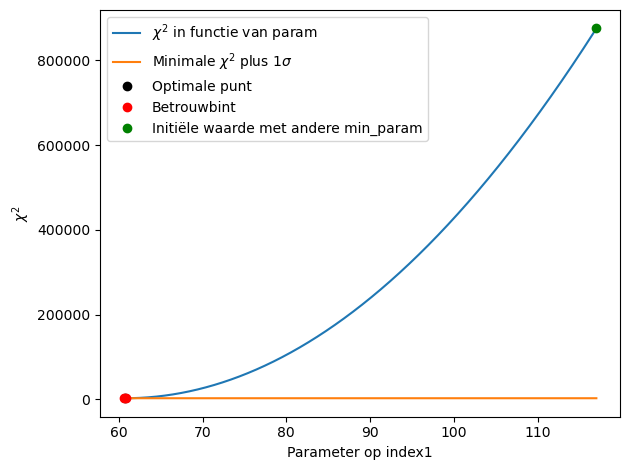

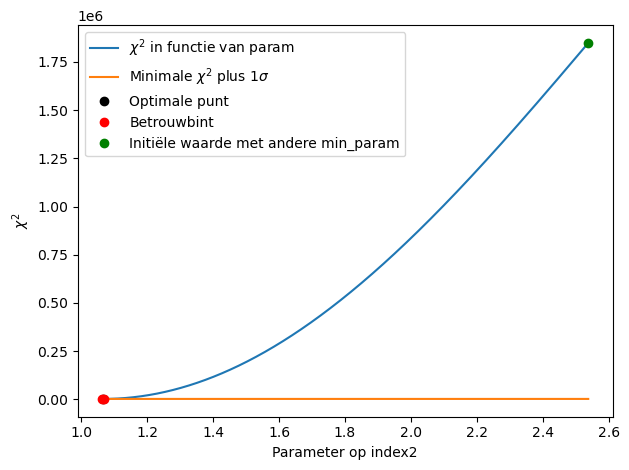

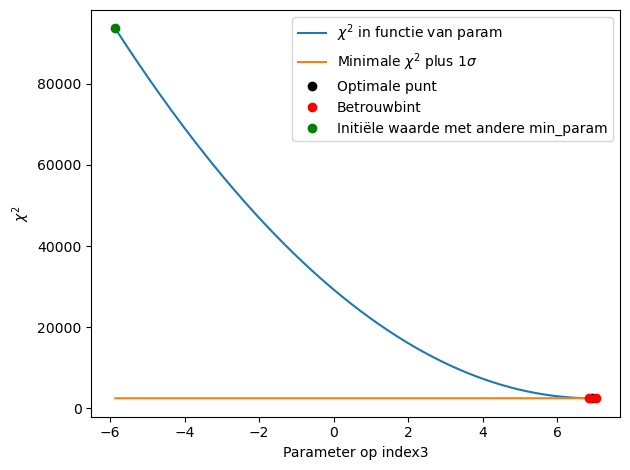

De p-waarde voor de hypothese test dat het model zinvol is, wordt gegeven door: 1
De gereduceerde chi^2 waarde is: 0.50436



[[0.0666434653833315, (1.8e-06, 0.042), 'S'], [60.74336197671342, 0.13, 'S'], [1.065641701493182, 0.0021, 'S'], [6.945215989863606, 0.092, 'S']] tijdfit


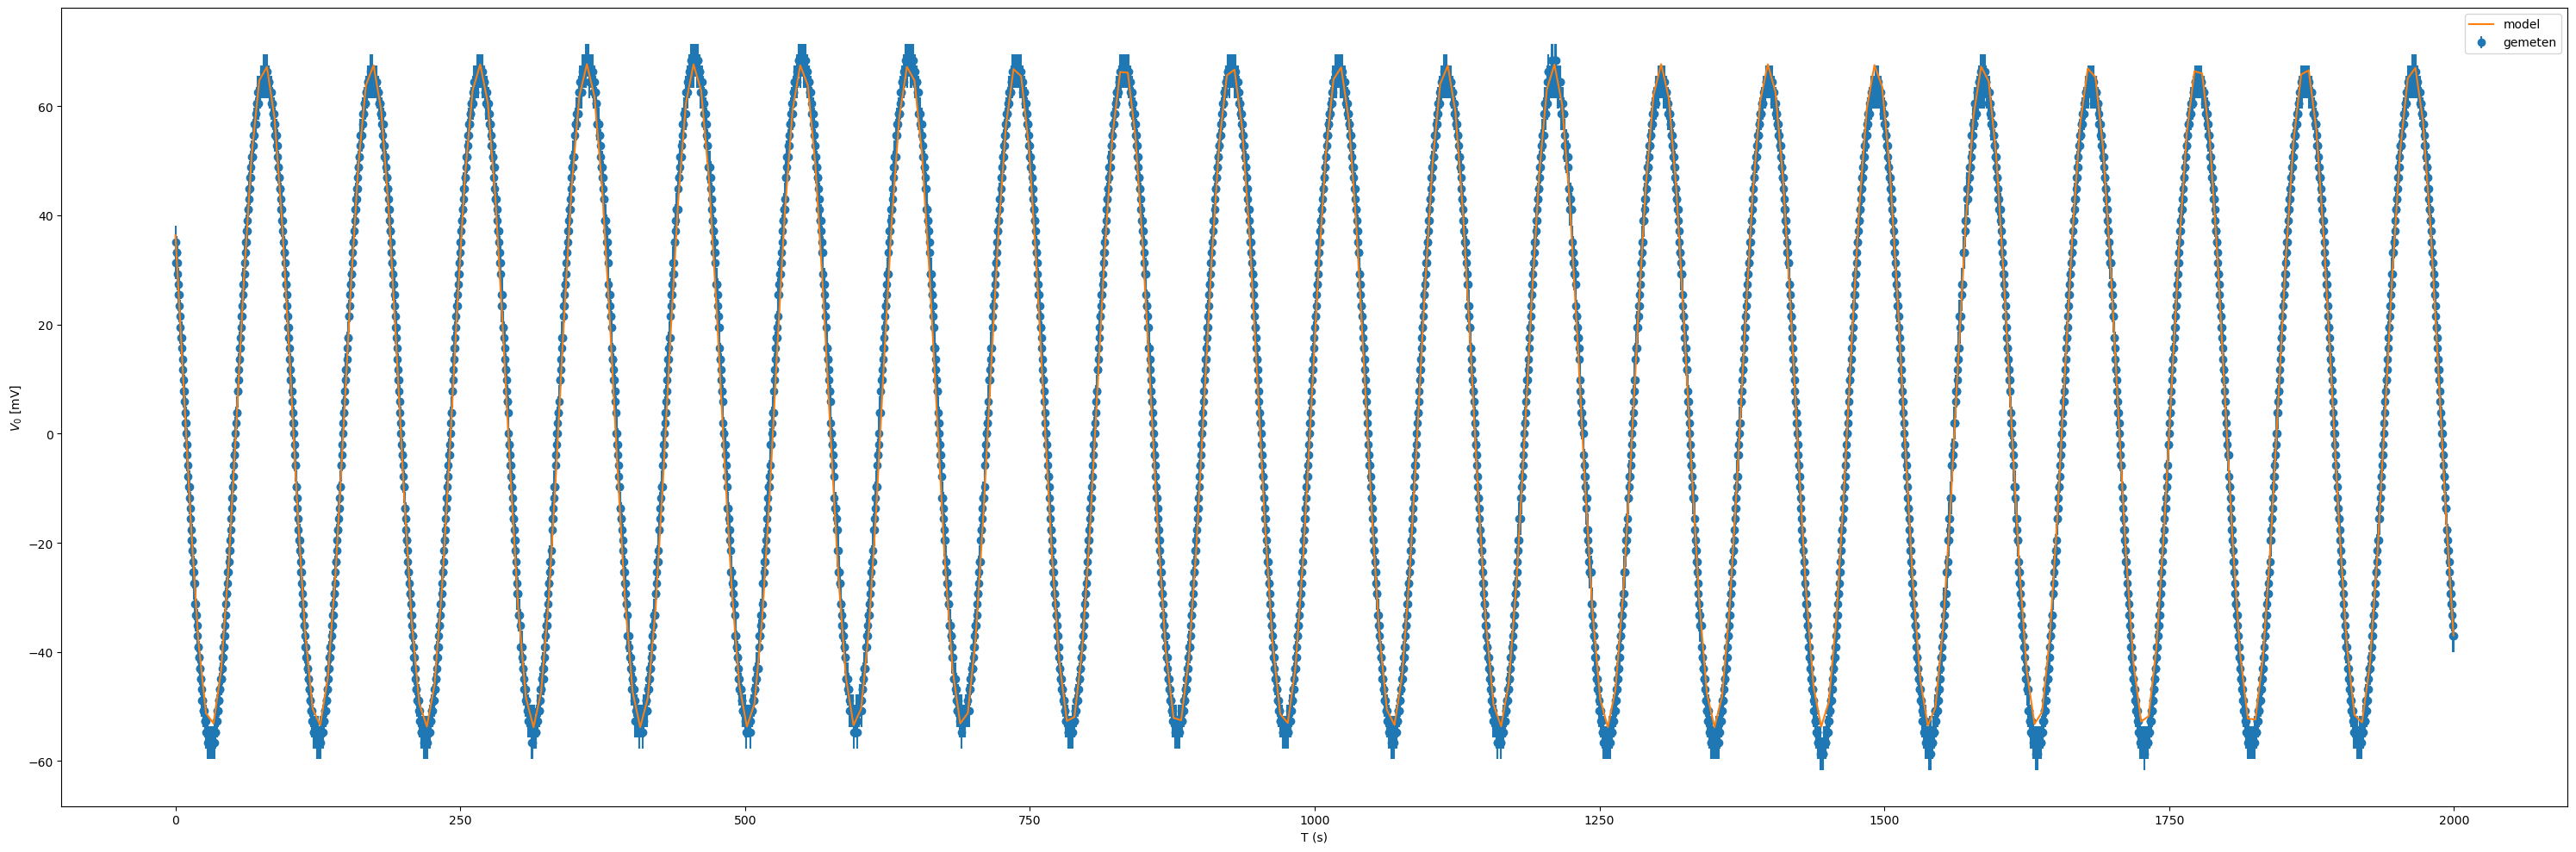

Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 3083.3292876596943
             x: [ 6.664e-02  8.281e+01  9.706e-01  5.925e+00]
           nit: 221
          nfev: 385
 final_simplex: (array([[ 6.664e-02,  8.281e+01,  9.706e-01,  5.925e+00],
                       [ 6.664e-02,  8.281e+01,  9.706e-01,  5.925e+00],
                       ...,
                       [ 6.664e-02,  8.281e+01,  9.706e-01,  5.925e+00],
                       [ 6.664e-02,  8.281e+01,  9.706e-01,  5.925e+00]]), array([ 3.083e+03,  3.083e+03,  3.083e+03,  3.083e+03,
                        3.083e+03]))
[[0.000439582065137723, 0.10847312798540819], [82.6806682872475, 82.94164421539536], [0.9690235305598942, 0.972152197369318], [5.833017060646344, 6.016883995636919]]
omega heeft als waarde: 0.066644 + 0.041829 - 0.066204 met 68% betrouwbaarheidsinterval: [0.00043958, 0.10847] 
p_0_x heeft als waarde: 82.811 + 0.13048 - 0.1305 met 68% betrouwb

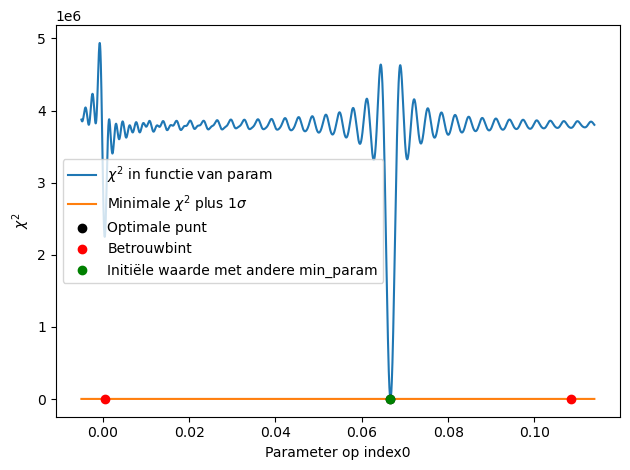

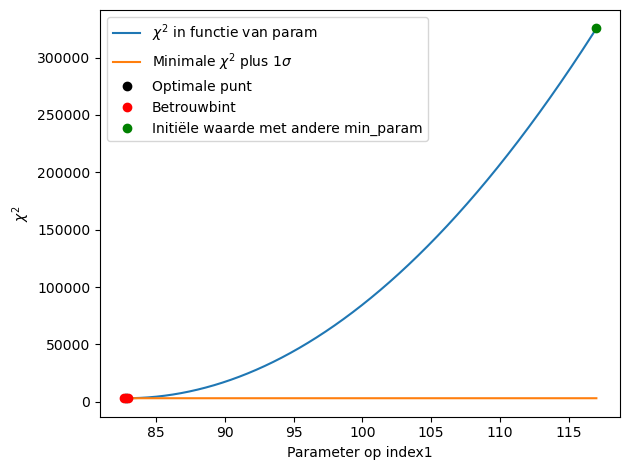

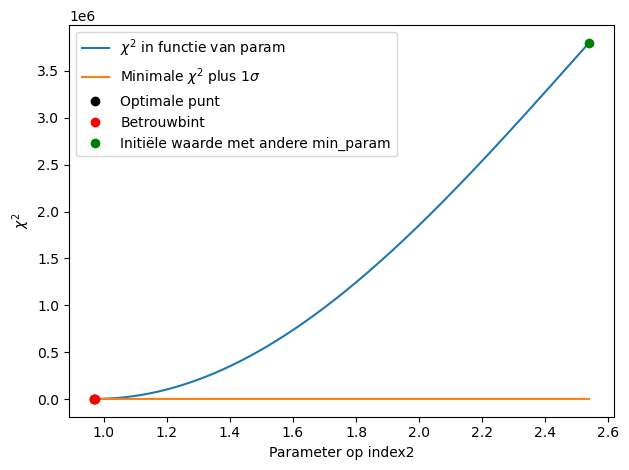

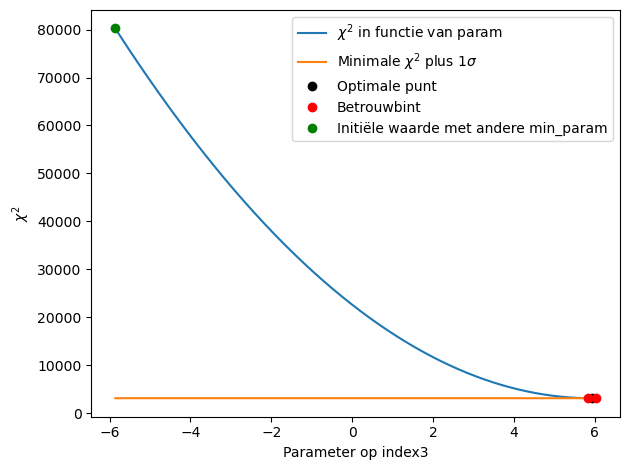

De p-waarde voor de hypothese test dat het model zinvol is, wordt gegeven door: 1
De gereduceerde chi^2 waarde is: 0.61716



[[0.0666436320523276, (0.066, 0.042), 'S'], [82.8111669829225, 0.13, 'S'], [0.9705876895939668, 0.0016, 'S'], [5.92490287014847, 0.092, 'S']] tijdfit


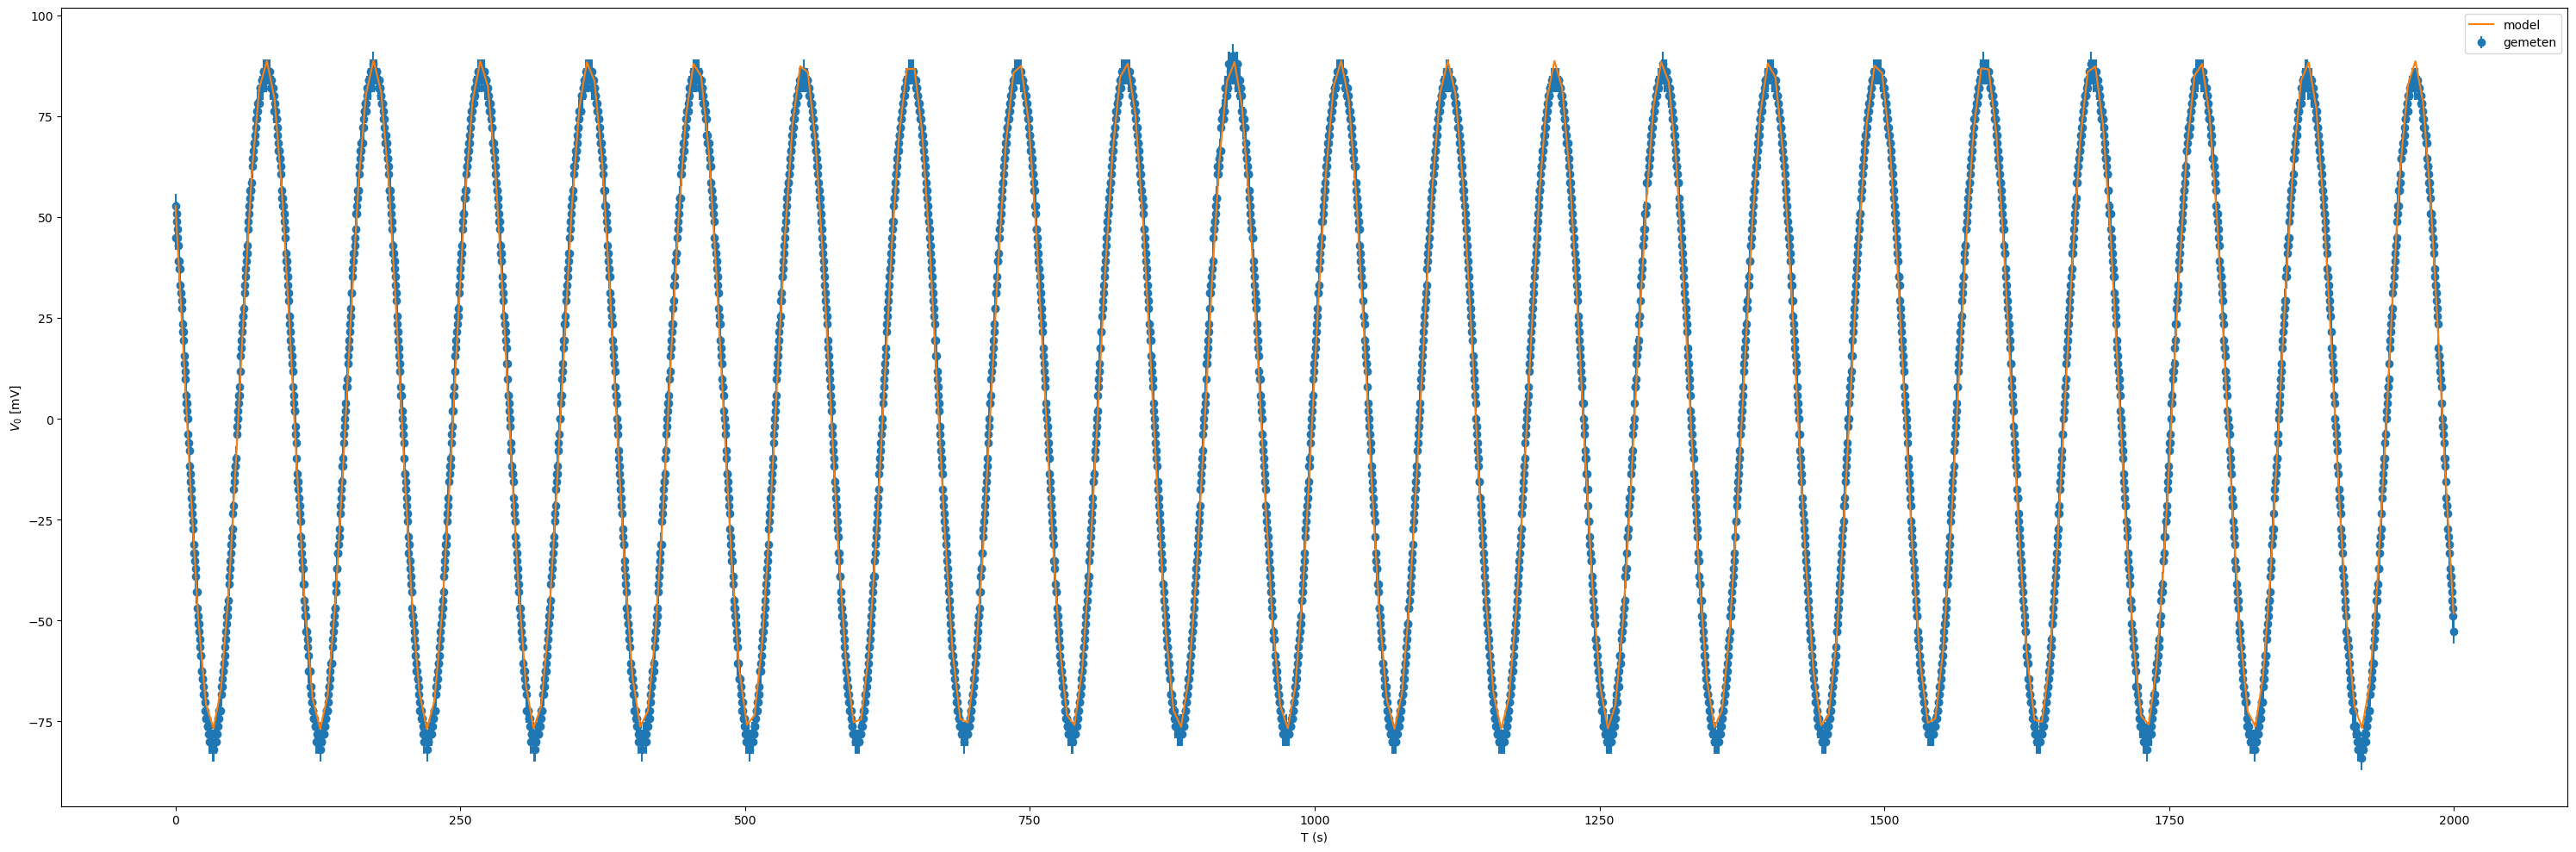

Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 7627.608032684651
             x: [ 6.665e-02  1.125e+02  9.597e-01  1.194e+00]
           nit: 257
          nfev: 446
 final_simplex: (array([[ 6.665e-02,  1.125e+02,  9.597e-01,  1.194e+00],
                       [ 6.665e-02,  1.125e+02,  9.597e-01,  1.194e+00],
                       ...,
                       [ 6.665e-02,  1.125e+02,  9.597e-01,  1.194e+00],
                       [ 6.665e-02,  1.125e+02,  9.597e-01,  1.194e+00]]), array([ 7.628e+03,  7.628e+03,  7.628e+03,  7.628e+03,
                        7.628e+03]))
[[0.011775855873186752, 0.06665060665527038], [112.378645336853, 112.63962482311469], [0.9585005140013428, 0.9608033054381114], [1.1017124706136883, 1.285579385191854]]
omega heeft als waarde: 0.06665 + 9.9585e-07 - 0.054874 met 68% betrouwbaarheidsinterval: [0.011776, 0.066651] 
p_0_x heeft als waarde: 112.51 + 0.13051 - 0.13047 met 68% betro

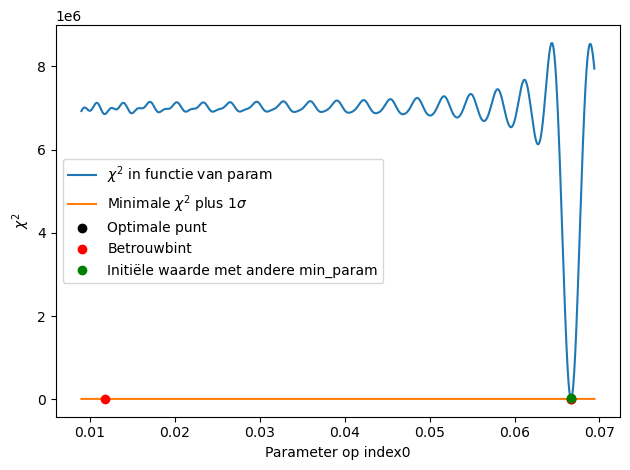

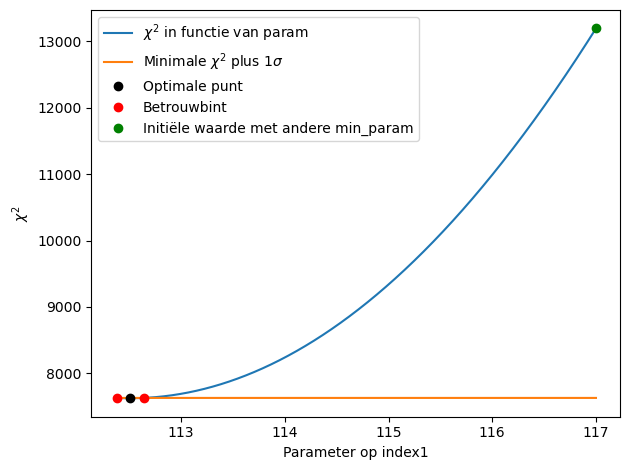

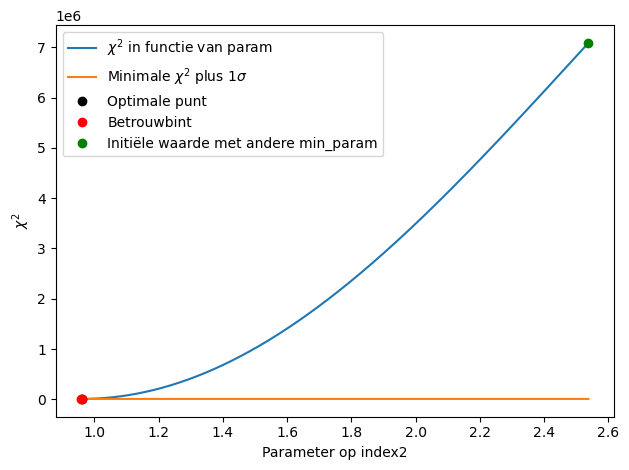

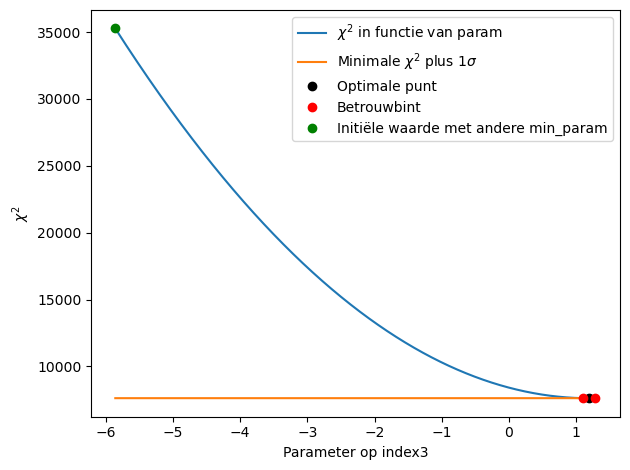

De p-waarde voor de hypothese test dat het model zinvol is, wordt gegeven door: 6.0317e-115
De gereduceerde chi^2 waarde is: 1.5267



[[0.06664961080355875, (0.055, 1e-06), 'S'], [112.5091109938183, 0.13, 'S'], [0.9596517302390761, 0.0012, 'S'], [1.1936260613238137, 0.092, 'S']] tijdfit


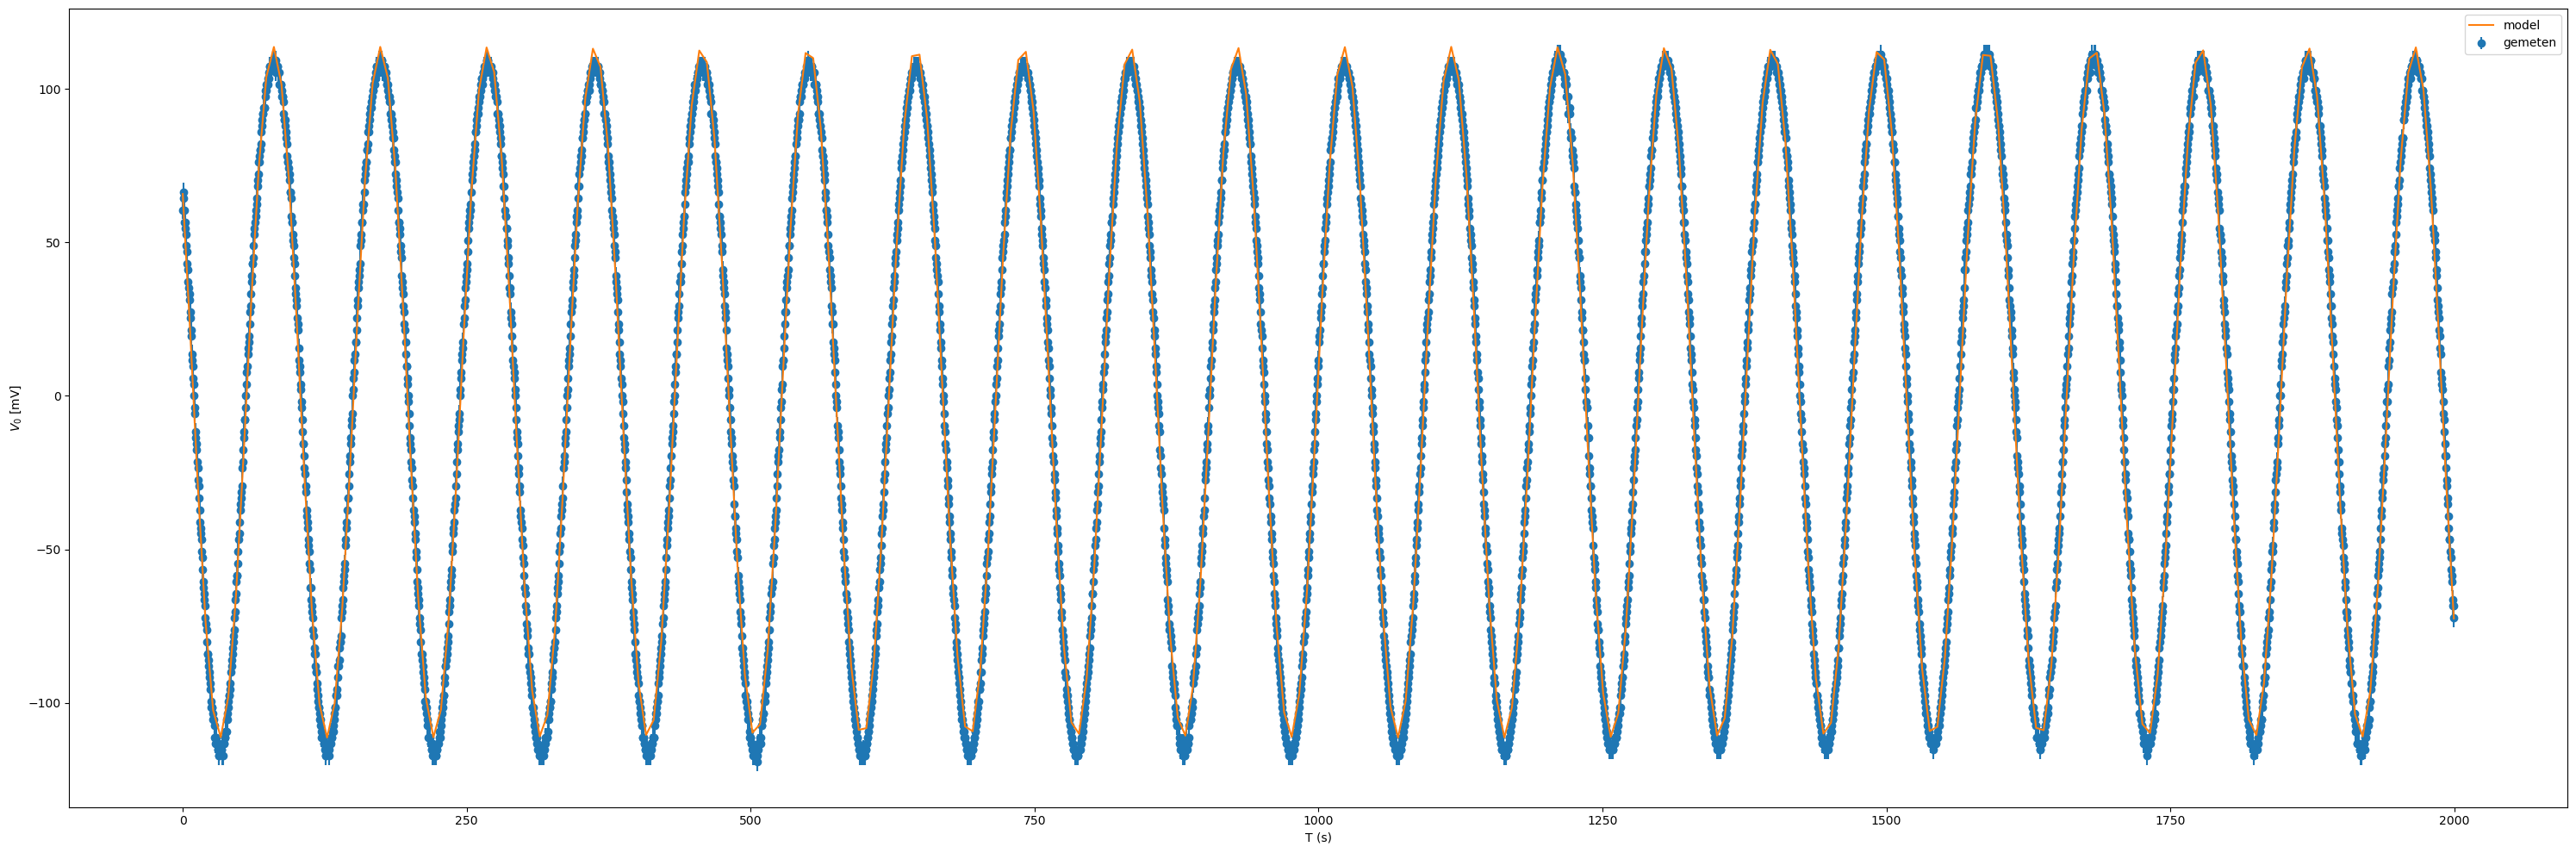

[0.13, 0.13, 0.13, 0.13, 0.13] P_0(x): de error
Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 2192.890869025593
             x: [ 2.893e+01  9.779e+01 -7.146e+00 -8.310e-01]
           nit: 470
          nfev: 791
 final_simplex: (array([[ 2.893e+01,  9.779e+01, -7.146e+00, -8.310e-01],
                       [ 2.893e+01,  9.779e+01, -7.146e+00, -8.310e-01],
                       ...,
                       [ 2.893e+01,  9.779e+01, -7.146e+00, -8.310e-01],
                       [ 2.893e+01,  9.779e+01, -7.146e+00, -8.310e-01]]), array([ 2.193e+03,  2.193e+03,  2.193e+03,  2.193e+03,
                        2.193e+03]))
[[28.943266560246403, 246.51165192257068], [97.60118840239667, 97.87523155857751], [-7.144948599234738, -0.8617632920551547], [-0.8322481947222405, -0.8296717347665483]]
k heeft als waarde: 28.93 + 217.58 - -0.013013 met 68% betrouwbaarheidsinterval: [28.943, 246.51] 
p_0 heeft als waarde: 97.793

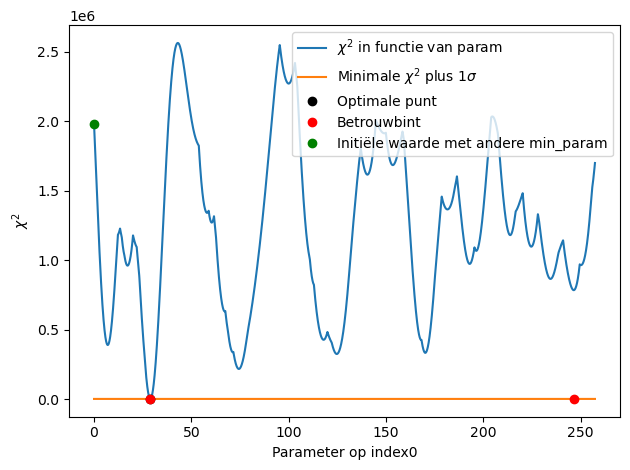

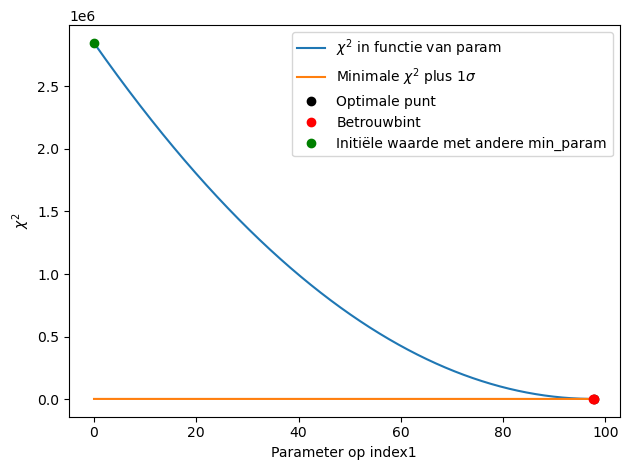

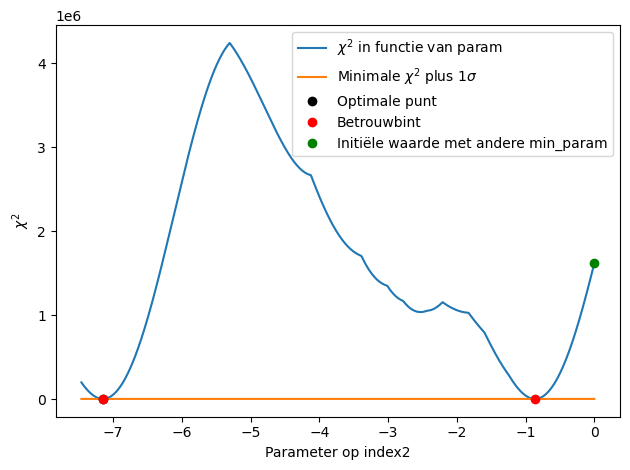

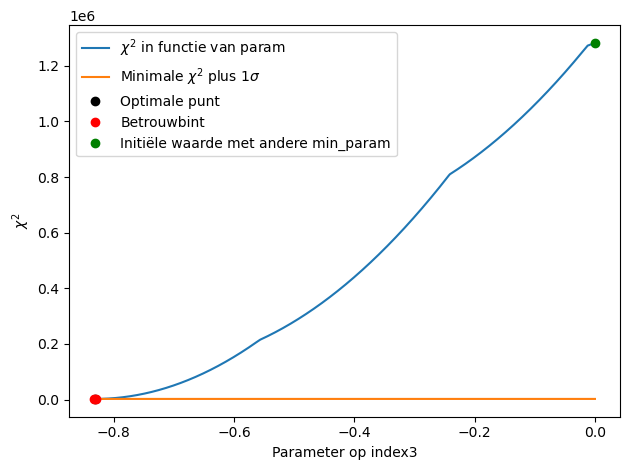

De p-waarde voor de hypothese test dat het model zinvol is, wordt gegeven door: 0
De gereduceerde chi^2 waarde is: 2192.9


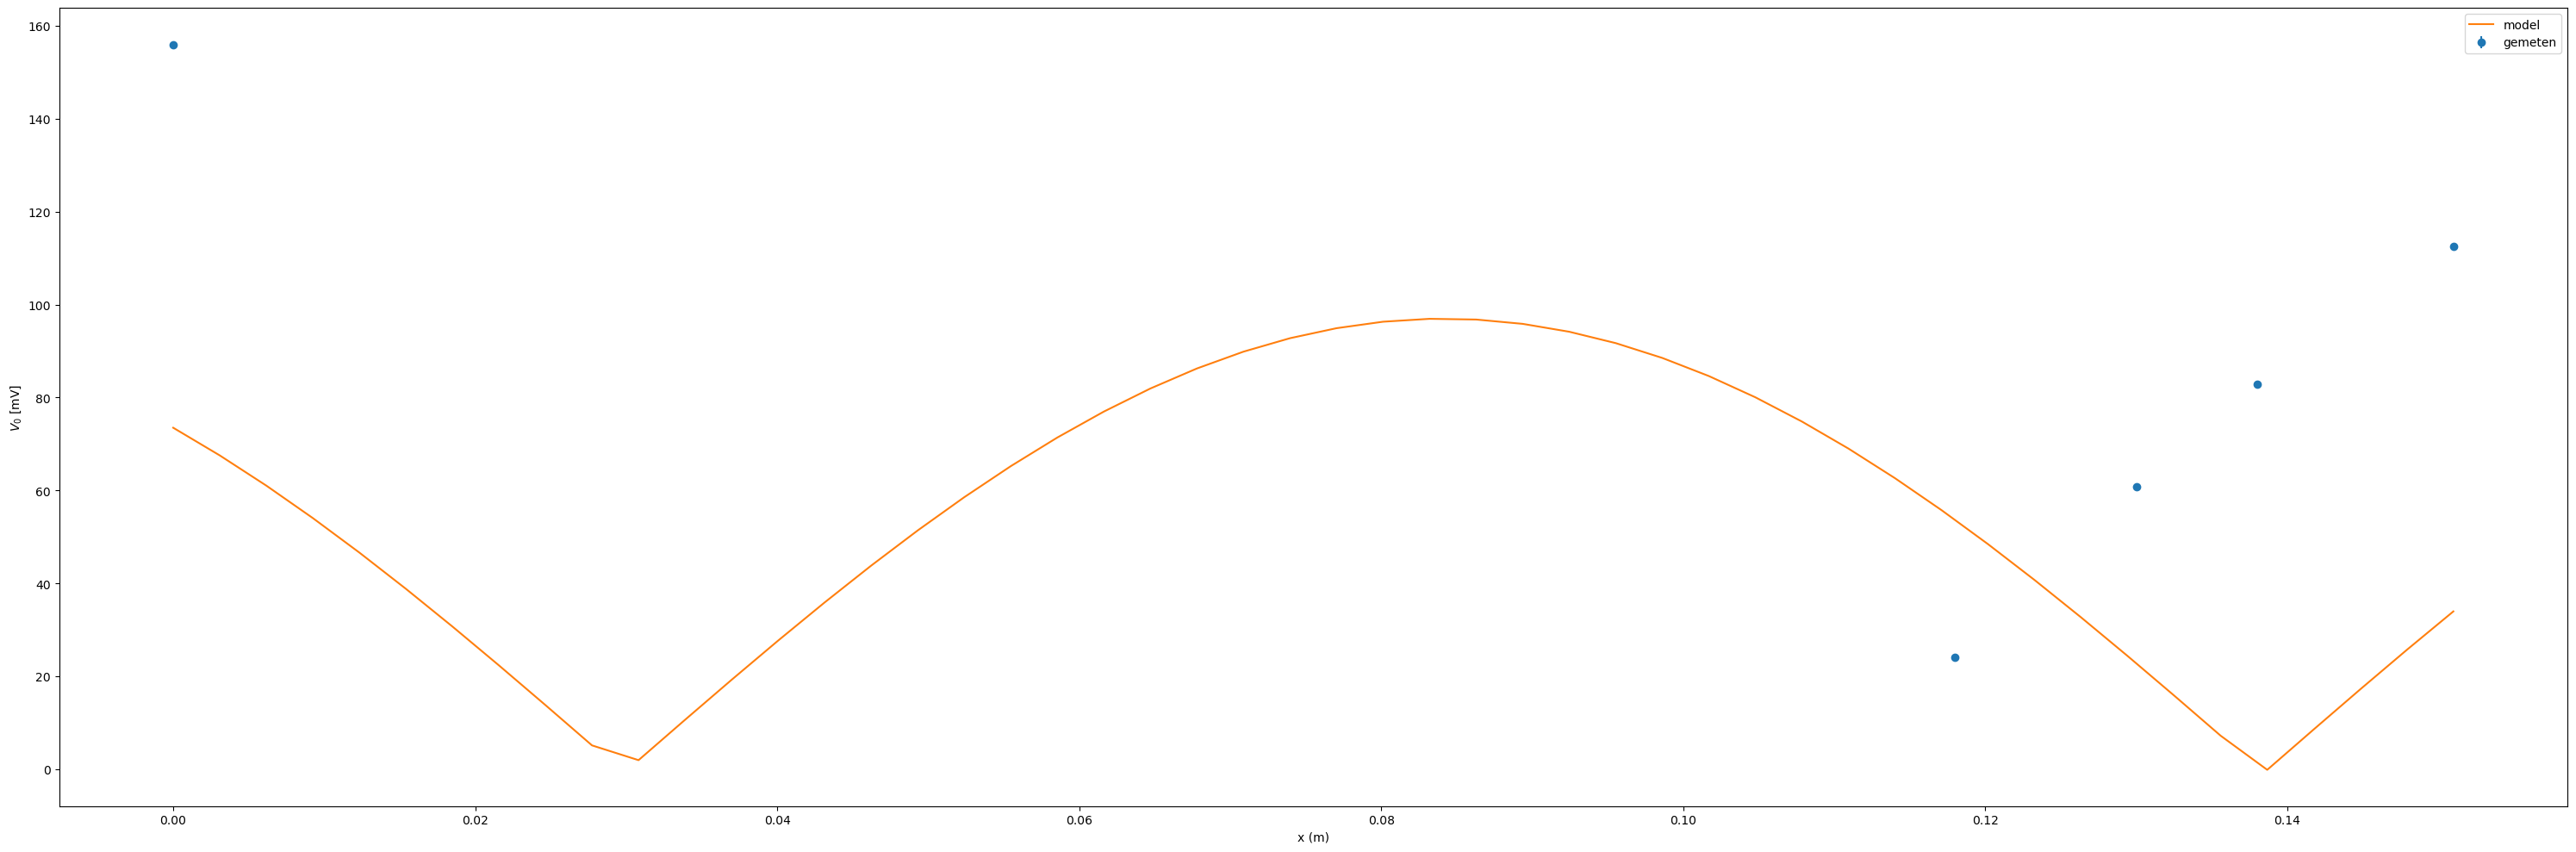

datapunt: v = [0.00230353848781868, 0.0175346555058303, 'Normaal']


In [72]:
fix_data(afstanden, T, V, V_fout, invals_vaste_x, detailed_logs=True)